# Notebook Setup

In [1]:
import os
import time
import math
import copy
import random
import pickle
import sklearn 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import Counter

from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier as kNN
from sklearn import preprocessing


In [2]:
data_path = "dataset/"
results_imdb_path = os.path.join(data_path, "results/imdb/")

In [3]:
if not os.path.isdir(data_path):
    os.mkdir(data_path)
if not os.path.isdir(results_imdb_path):
    os.makedirs(results_imdb_path)

# Task 1: Data preprocessing

## Task 1.1. IMDB DATA
### Read Data

####  Get total vocab in the dataset

In [49]:
files_voc = os.path.join(data_path, "imdb/imdb.vocab")
if not os.path.isfile(files_voc):
    print("File don't exist please create an imdb folder and download the dataset in it.")

In [50]:
vocab_total=[]
with open(files_voc, 'r', encoding='utf-8') as f0:
    for line in f0.readlines():
        vocab_total.append(line[:-1])
f0.close()
print("Number of used words in the imdb dataset: ", len(vocab_total)) # total size: 89527

Number of used words in the imdb dataset:  89527


In [6]:
print("First five words: ", vocab_total[:5]) 

First five words:  ['the', 'and', 'a', 'of', 'to']


####  Get train and test tokenized bag of words (BoW) features

In [7]:
files_BOW = os.path.join(data_path, "imdb/train/labeledBow.feat")
if not os.path.isfile(files_voc):
    print("File don't exist please create an imdb folder and download the dataset in it.")

In [8]:
# load the BOW training set 
label_BOW_train=[]
with open(files_BOW, 'r', encoding='utf-8') as f0:
    for line in f0.readlines():
        label_BOW_train.append(line[:-1])
f0.close()
print("Number of reviews in train: ", len(label_BOW_train)) # total size: 89527

Number of reviews in train:  25000


In [9]:
files_BOW = os.path.join(data_path, "imdb/test/labeledBow.feat")
if not os.path.isfile(files_voc):
    print("File don't exist please create an imdb folder and download the dataset in it.")

In [10]:
# load the BOW testing set for usage 
label_BOW_test=[]
with open(files_BOW, 'r', encoding='utf-8') as f0:
    for line in f0.readlines():
        label_BOW_test.append(line[:-1])
f0.close()
print("Number of reviews in train: ", len(label_BOW_test)) # total size: 89527

Number of reviews in train:  25000


### Preprocess Data 

#### Task 1.1. (a) Filtering out the rare and stopwords

In [11]:
# establish a dictionary to save the indexes and values
dict_train={}
for i in range(len(label_BOW_train)): # iterate through reviews in train
    
    list_save_keys=list()
    dict_train_add=dict()
    
    for j in range (len(label_BOW_train[i][2:].split())): #iterate through number of words in the review
        list_save_keys.append(label_BOW_train[i][2:].split()[j].split(":")[0])

    for k in list_save_keys: # if the word appears in one review, its corresponding value +1
        dict_train_add[k]=1
    
    X,Y= Counter(dict_train), Counter(dict_train_add) 
    dict_train=dict(X+Y) # add up the words' appearances and save it into a dictionary 'dict_train'

In [12]:
# save the dictionary
w = csv.writer(open(os.path.join(results_imdb_path, "train_dict.csv"), "w"))

# loop over dictionary keys and values
for key, val in dict_train.items():
    # write every key and value to file
    w.writerow([key, val])

In [13]:
# show each word's occ w.r.t. the word index
csv_train=pd.read_csv(os.path.join(results_imdb_path, "train_dict.csv" ), names=["word", "occ"])

In [14]:
csv_train.head()

,word,occ
0,0,24792
1,1,24162
2,2,24173
3,3,23722
4,4,23459


In [16]:
# save the dictionary as csv
with open(os.path.join(results_imdb_path, "dict.pickle"), 'wb') as f:
    pickle.dump(dict_train, f)

In [17]:
# uncomment if you want to load the dict directly and continue working from here

# with open(os.path.join(results_imdb_path, "dict.pickle"), 'rb') as f:
#     x = pickle.load(f)

In [18]:
# our threshold for the rare and “stopwords”
thres_rare = int(len(label_BOW_train)*0.01) # lower bound: 250 times
thres_stopwords = int(len(label_BOW_train)*0.5) #  upper bound: 12500 times

In [19]:
# keep the keys have values between 1% and 50%. i.e., filtering out the stopwords. 
filtered_dict= [k for k,v in dict_train.items() if v>= thres_rare and v <= thres_stopwords] 

In [20]:
# checking how many words left
print("Number of left words", len(filtered_dict)) 

Number of left words 1744


In [21]:
# save the words in the filtered dictionary 
vocab_filter=list()
for x in filtered_dict[0:len(filtered_dict)]:
    vocab_filter.append(vocab_total[eval(x)])

#### Task 1.1. (b) Calculating the absolute z-scores

In [22]:
# we want to choose features according to z-scores calculated by X (features) and Y (labels)
# Therefore we need to define X and Y

In [23]:
# For Y (labels)
label_imdb_train= []

for i in range (len(label_BOW_train)):
    label_imdb_train.append(label_BOW_train[i].split()[0])

In [24]:
# For X (features), note they are filtered features
features_imdb_list=[ [] for x in range(len(filtered_dict))]
for file in range(len(label_BOW_train)):

    for num in filtered_dict:
        # take the first part of value in coded data type "A:B", which is "A"
        element_add= [s for s in label_BOW_train[file][2:].split() if s.startswith(num +':')]
        if element_add==[]: # if that word not appear in a review, we give it a 0 number
            num_add=0
        else:
            num_add=eval(element_add[0].split(":")[1]) # if that word appears, we save "B" in "A:B"
        features_imdb_list[filtered_dict.index(num)].append(num_add)

In [121]:
## TASK 3.1
## (1) Report the top 10 features with the most positive z-scores and the top 10 features with the most negative z-scores on the IMDB data using 
## simple linear regression on the movie rating scores.

In [123]:
# we can therefore calculate absolute z-scores
absolute_z_score=[]
for k in range(len(features_imdb_list)):

    x=preprocessing.scale(features_imdb_list[k]) # standardize "X" (features)
    y=preprocessing.scale(label_imdb_train)      # standardize "Y" (labels)
    absolute_z_score.append(sum(np.multiply(x,y))/math.sqrt(25000))# sqrt(N)=sqrt(25000)

In [51]:
# take the D features with largest (top) z-scores
D= 200 # D-value can be changed in [100,1000], we take 200 
copy_set=copy.deepcopy(absolute_z_score)
max_num=[]
max_index=[]

for _ in range(D):
    num= max(copy_set)
    index=copy_set.index(num)
    copy_set[index]=0
    max_num.append(num)
    max_index.append(index) # save the indexes of these features with top 200 z-scores
copy_set=[]

vocab_max_z=list()
for x in max_index:
    vocab_max_z.append(vocab_total[x])
print("Features with maximum z-scores (top 10) are: ",vocab_max_z[0:10])

Features with maximum z-scores (top 10) are:  ['years', 'decided', 'feel', 'reason', 'nothing', 'created', 'talk', 'feeling', 'japanese', 'performance']


In [52]:
# take the smallest (minimum) D features 
D= 200 # # D-value can be changed in [100,1000], we take 200 
import copy
copy_set=copy.deepcopy(absolute_z_score)
min_num=[]
min_index=[]

for _ in range(D):
    num= min(copy_set)
    index=copy_set.index(num)
    copy_set[index]=0
    min_num.append(num)
    min_index.append(index)# save the indexes of these features with smallest 200 z-scores
copy_set=[]

vocab_min_z=list()
for x in min_index:
    vocab_min_z.append(vocab_total[x])
print("Features with minimum z-scores (bottom 10) are: ", vocab_min_z[0:10])

Features with minimum z-scores (bottom 10) are:  ['sweet', 'hot', 'random', 'knowing', 'best', 'terrific', 'industry', 'did', 'british', 'storyline']


In [29]:
# For the testing dataset, do the same preprocessing steps

# for Y (labels)
label_test= []

for i in range (len(label_BOW_test)):
    label_test.append(label_BOW_test[i].split()[0])

# For X (filtered features)     
features_list_test=[ [] for x in range(len(filtered_dict))]
for file in range(len(label_BOW_test)):
    for num in filtered_dict:
        element_add= [s for s in label_BOW_test[file][2:].split() if s.startswith(num +':')]
        if element_add==[]:
            num_add=0
        else:
            num_add=eval(element_add[0].split(":")[1])
        features_list_test[filtered_dict.index(num)].append(num_add)

In [37]:
# saving the results for use
filtered_index=np.array(filtered_dict)
np.save(os.path.join(results_imdb_path,'filtered-index.npy'), filtered_index)

# if you want to read the file 
#filtered_dict=np.load(os.path.join(results_imdb_path,'filtered-index.npy'))
#filtered_dict=filtered_dict.tolist()
#filtered_dict

In [42]:
features_list=np.array(features_imdb_list)
np.save(os.path.join(results_imdb_path, 'selected-feature-list.npy'), features_list)

# if you want to read the file 
#features_list=np.load(os.path.join(results_imdb_path,'selected-feature-list.npy'))
#features_list=features_list.tolist()
#features_list

In [41]:
absolute_z_score= np.array(absolute_z_score)
np.save(os.path.join(results_imdb_path, 'absolute_z_score.npy') ,absolute_z_score)

#absolute_z_score=np.load(os.path.join(results_imdb_path, 'absolute_z_score.npy'))
#absolute_z_score=absolute_z_score.tolist()
#absolute_z_score

In [43]:
features_list=np.array(features_list_test)
np.save(os.path.join(results_imdb_path, 'selected-feature-list-test.npy'), features_list)

# if you want to read the file 
#features_list=np.load(os.path.join(results_imdb_path,'selected-feature-list-test.npy'))
#features_list=features_list.tolist()
#features_list

In [46]:
label_test=np.array(label_test)
np.save(os.path.join(results_imdb_path, 'label_test.npy'), label_test)

label_train=np.array(label_imdb_train)
np.save(os.path.join(results_imdb_path, 'label_train.npy'), label_train)


## Task 1.2.  Twenty news groups data

### Read Data

In [4]:
from sklearn.datasets import fetch_20newsgroups
newsgroups=sklearn.datasets.fetch_20newsgroups
categories=['comp.graphics','rec.sport.hockey','sci.med', 'soc.religion.christian'] # the 4 categories we will work with

In [5]:
# select train and test sets
twenty_train=newsgroups(subset='train',categories=categories,
                           #shuffle=True, random_state=42,  # uncomment this if want a quick training
                            remove=(['headers', 'footers', 'quotes']))

twenty_test=newsgroups(subset='test',categories=categories,
                           #shuffle=True, random_state=42,  # similar for this
                            remove=(['headers', 'footers', 'quotes']))

In [6]:
print("Number of sentences in the 20 new group train set: ", len(twenty_train.data))

Number of sentences in the 20 new group train set:  2377


In [7]:
print("Number of sentences in the 20 new group test set: ", len(twenty_test.data))

Number of sentences in the 20 new group test set:  1582


### Proprecess the data 

In [8]:
# Similar to Task 1.1, this time we use e Mutual Information (MI) to select features
# To calculate MI, we still need features (X) and labels (Y)
# we will need an one-hot encoding for y to enter the model

In [9]:
# For labels (Y), we need one-hot-encoding to turn Y={0,1,2,3} to 4 binary variables (Y1-Y4)
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder()
one_hot_enc_Y = ohe.fit_transform(twenty_train.target.reshape(-1, 1))

In [10]:
twenty_train.data[0]

"It is not true that dermatologists gave not reached the laser age, in\nfact, lasers in dermatological surgery is a very new and exciting field.\n\nIt probably won't be effective in tinea pedis because the laser is\nusually a superficial burn (to avoid any deeper damage). Limited tinea\npedis can be cured albeit sometimes slowly by topical antifungals as\nwell as systemic medication i.e. tablets. Finally, a self-diagnosis is\nnot always reliable, lichen simplex chronicus can look like a fungal\ninfection and requires very different treatment."

In [11]:
# For features (X), we first extract them with a sparse matrix
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(twenty_train.data)
X_train_counts.shape 
dense_X_train_counts=np.asarray(X_train_counts.todense())# then transfer it into a dense matrix

In [12]:
print("Number of words in the 20 new group trainset: ", len(dense_X_train_counts[0]))

Number of words in the 20 new group trainset:  30945


In [13]:
# we also do the same process for the testing set:

# for labels(Y):
one_hot_enc__test_Y = ohe.transform(twenty_test.target.reshape(-1, 1))
# for X ,which is features(same as the train set):
X_test_counts = count_vect.transform(twenty_test.data)
X_test_counts.shape
dense_X_test_counts=np.asarray(X_test_counts.todense()) # tranfer the sparse matrix into a dense one, save for usage


In [14]:
# preparing data for train
X_train_20news=X_train_counts.toarray()
Y_train_20news=one_hot_enc_Y.toarray()
X_test_20news=X_test_counts.toarray()
Y_test_20news=one_hot_enc__test_Y.toarray()

In [15]:
# our threshold for the rare and “stopwords”, similar to Task 1.1, we have:
thres_rare_task_2 = int(X_train_counts.shape[1]*0.01) # lower bound: 309.45 times
thres_stopwords_task_2 = int(X_train_counts.shape[1]*0.5) #  upper bound: 15472.5 times

In [16]:
# For features
# filter the features from the whole (count_vect.vocabulary_)
filter_vect= dict()
filter_vect_index=[]
for i in count_vect.vocabulary_.keys():
    # two threshold, since the frequency of words are integers:
    if count_vect.vocabulary_[i]> thres_rare_task_2 and count_vect.vocabulary_[i]< thres_stopwords_task_2: 
 
        filter_vect[i]=count_vect.vocabulary_[i]
        filter_vect_index.append(list(count_vect.vocabulary_.keys()).index(i))

print("The length of filtered features is: ",len(filter_vect))

The length of filtered features is:  15162


In [17]:
# We can therefore calculate the MI.

# calculate MI scores for the 4 types of labels (after one-hot encoding)
MI_y1=[]
MI_y2=[]
MI_y3=[]
MI_y4=[]
for i in range(len(filter_vect)):
    # MI between X and Y1
    score1=sklearn.metrics.mutual_info_score(np.ravel(dense_X_train_counts[:,filter_vect_index[i]]),
                                  one_hot_enc_Y.toarray()[:,0],
                                 contingency=None)
    # MI between X and Y2
    score2=sklearn.metrics.mutual_info_score(np.ravel(dense_X_train_counts[:,filter_vect_index[i]]),
                                  one_hot_enc_Y.toarray()[:,1],
                                 contingency=None)
    # MI between X and Y3
    score3=sklearn.metrics.mutual_info_score(np.ravel(dense_X_train_counts[:,filter_vect_index[i]]),
                                  one_hot_enc_Y.toarray()[:,2],
                                 contingency=None)
    # MI between X and Y4
    score4=sklearn.metrics.mutual_info_score(np.ravel(dense_X_train_counts[:,filter_vect_index[i]]),
                                  one_hot_enc_Y.toarray()[:,3],
                                 contingency=None)
    MI_y1.append(score1)
    MI_y2.append(score2)
    MI_y3.append(score3)
    MI_y4.append(score4)

In [18]:
def select_top_M_feature(M, MI):
    copy_set=copy.deepcopy(MI)
    max_num=[]
    max_index=[]
    for _ in range(M):
        num= max(copy_set)
        index=copy_set.index(num)
        copy_set[index]=0
        max_num.append(num)
        max_index.append(index)# save words' indexes with top MI for Y"i"
    copy_set=[]
    vocab_max_MI=list()
    for x in max_index:
        vocab_max_MI.append(list(count_vect.vocabulary_.keys())[x])
    return max_index, vocab_max_MI

In [19]:
# checking the features and their indexes we have selected for y1
M=100 # M in [10,100], we choose M=50 
max_index_y1, vocab_max_MI_y1 =  select_top_M_feature(M, MI_y1)

In [20]:
print("Show 10 words with top MI for label Y1: ",vocab_max_MI_y1[:10])

Show 10 words with top MI for label Y1:  ['archivevol2', '164', 'tumor', 'bankrupt', 'listening', 'strictly', 'root', 'negroid', '246', 'analgesic']


In [21]:
# for Y2-Y4, we proceed the same as Y1:
max_index_y2, vocab_max_MI_y2 =  select_top_M_feature(M, MI_y2)
max_index_y3, vocab_max_MI_y3 =  select_top_M_feature(M, MI_y3)
max_index_y4, vocab_max_MI_y4 =  select_top_M_feature(M, MI_y4)

In [22]:
# union of all top features among y1-y4, to train the multiclass model
union_features= list(set(max_index_y1) | set(max_index_y2) | set(max_index_y3) | set(max_index_y4))
print("The length of the union filtered features is: ",len(union_features))

The length of the union filtered features is:  288


In [23]:
X_train_filtered_20news=X_train_20news[:,filter_vect_index]
X_test_filtered_20news=X_test_20news[:,filter_vect_index]

In [24]:
X_train_selected_20news=X_train_20news[:,union_features]
X_test_selected_20news=X_test_20news[:,union_features]

# Task 2: Implement Logistic and Multiclass classifiers

## Gradient Descent Classes

In [25]:
class GradientDescent:

    def __init__(self, learning_rate=1e-3, max_iters=1e4, epsilon=1e-8, record_history=False, verbose=False):
        """ 
        Input
            learning_rate   
            max_iters       max iters for gradient descent (part of stopping condition)
            epsilon         the 'super small value'
            record_history  array to store the weights over all iterations
            verbose
        Output
            None
        """
        self.learning_rate = learning_rate  # indicates how big our steps are to the minimum
        self.epsilon = epsilon              # to get the tolerance for the norm of gradients 
        self.max_iters = max_iters          # maximum number of iteration of gradient descent
        self.record_history = record_history
        self.verbose = verbose
        if record_history:
            self.w_history = []                  # to store the weight history for visualization
            

    def run(self, gradient_fn, X, y, w, loss, X_valid=None, y_valid=None, early_stopping=False, look_back=1):
        """ 
        Input
            gradient_fn         the gradient of our loss function
            X                   features
            y                   labels
            w                   initial weights
            loss                the cost function we are using to evaluate the weights (ex. MSE, CE)
            X_valid, y_valid    indicates if we are using validation data during gradient descent
        Output
            w                   optimized weights 
            losses_train        loss on training set 
            losses_valid        loss on validation set, if using
        """
        losses_train = np.zeros(self.max_iters)
        losses_valid = np.zeros(self.max_iters)
        grad = np.inf
        t = 1

        if self.record_history:
            self.w_history.append(w)                # store initial weights before the iterative update
        
        # Start gradient descent
        while np.linalg.norm(grad) > self.epsilon and t < self.max_iters+1: # we start from 1; add 1 to max to reach total iters    
            shuffled_indices = np.asanyarray(range(X.shape[0])) 
            random.shuffle(shuffled_indices)    # new shuffled indices

            X = X[shuffled_indices]
            y = y[shuffled_indices]


            grad = gradient_fn(X, y, w)             # compute the gradient with present weight
            w = w - self.learning_rate * grad       # weight update step
            loss_train = loss(X, y, w)            # calculate the loss, using the data and current w value
            losses_train[t-1] = loss_train

            if self.record_history:
                self.w_history.append(w)            # append our new weights if we are keeping track of them 
            
            if X_valid is not None and y_valid is not None: # check weights on vlidation data, if using
                loss_valid = loss(X_valid, y_valid, w)    # calculate and store loss on the validation data
                losses_valid[t-1] = loss_valid
                if ( t % 100 )==0 or t==1:                  # print loss each 100 iteration
                    print(f"epoch {t}: {loss_train:.3f}; {loss_valid:.3f}")
                if early_stopping and t > look_back:
                    loss_is_greater = (loss_valid > np.mean(losses_valid[t-1-look_back:t-1]))  # compare current validation
                    # to the mean of i last validation losses
                    if loss_is_greater:
                        print(f'Early stopping at epoch {t} due to increase in validation loss.')
                        loss_train=loss_train[:t-1]
                        break   # ensures we stop (will break us out of while loop)
            else:
                if ( t % 100 )==0 or t==1:                  # print loss each 100 iteration

                    print(f"training loss of epoch {t}: {loss_train:.3f}")

            t += 1
        
        # Gradient descent is done now ----------

        print()

        if self.verbose:
            print(f'terminated after {t} epochs, with norm of the gradient equal to {np.linalg.norm(grad)}')
            # print(f'the weight found: {w}') # i removed the self.w This is just teh most recent

        return w, losses_train, losses_valid

In [26]:
optimizer_GD = GradientDescent(learning_rate=5e-3, max_iters=50, record_history=True)

### SGD

In [27]:
class StochasticGradientDescent:

    def __init__(self, learning_rate=1e-4, momentum=0, max_iters=1e4, epsilon=1e-8, minibatch_size = 1, record_history=False, verbose=False):
        """
        Select input
            minibatch_size      How many training points are looked at for each weight update. Deafault is a single point
        Output
        """
        self.learning_rate = learning_rate  # indicates how big our steps are to the minimum
        self.momentum = momentum            # momentum=0 : Normal SGD
        self.epsilon = epsilon              # to get the tolerance for the norm of gradients 
        self.max_iters = max_iters          # maximum number of iteration of gradient descent
        self.record_history = record_history
        self.verbose = verbose
        self.minibatch_size = minibatch_size
        if record_history:
            self.w_history = []                  # to store the weight history for visualization

    def run(self, gradient_fn, X, y, w, loss, X_valid=None, y_valid=None, early_stopping=False, look_back=1):
        """ 
        Input
            gradient_fn         gradient function 
            X                   features
            y                   labels
            w                   initial weights
            loss                loss function we are using
            X_valid             validation feats, if using
            y_valid             validation labels, if using
            early_stopping
            look_back
        Output
        """
        # set up th training loss for max iterations (this acts as epochs)
        losses_train = np.zeros(self.max_iters)
        losses_valid = np.zeros(self.max_iters)

        grad = np.inf
        if self.record_history:
            self.w_history.append(w)                 # store initial weights before the iterative update

        epoch = 1   
        # we have up to "self.max_iters" epochs
        # for each epoch, we will have a certain number of minibatches
        # we want to calculate the loss on all of the minibatches, and then sum the loss to get the loss on the current epoch
            
        # Gradient descent starts here
        # here, t is acting like EPOCHS
        while np.linalg.norm(grad) > self.epsilon and epoch < self.max_iters+1:   
            # we are now going to be dealing with a SINGLE EPOCH

            # shuffle the data
            shuffled_indices = np.asanyarray(range(X.shape[0])) 
            random.shuffle(shuffled_indices)    # new shuffled indices
            X_shuffled = X[shuffled_indices]
            y_shuffled = y[shuffled_indices]
            grad_prev = 0 # Grad previous: This is in case we have momentum, we start by intializing grad_prev
            # to zero for the first iteration as there is not prev grad to take into consideration


            # now, we will go through all of the minibatches
            # in the case where minibatch size is 1000, we will have 25 minibatches in total
            # in each minibatch, we take all of the datapoints together to make the loss and do the weight updates

            num_mini_batches = X.shape[0]//self.minibatch_size

            # store the loss of each minibatch
            minibatch_losses_train = np.zeros(num_mini_batches)
            minibatch_losses_valid = np.zeros(num_mini_batches)
            
            
            for n in range(num_mini_batches):
                
                # Set endpoints for minibatches
                minibatch_start_index = n * self.minibatch_size
                minibatch_end_index = minibatch_start_index + self.minibatch_size

                # define current minibatch data
                minibatch_X = X_shuffled[minibatch_start_index:minibatch_end_index]
                minibatch_y = y_shuffled[minibatch_start_index:minibatch_end_index]

                # updates the weights right after seeing EACH MINIBATCH of training examples (we added this)
                grad = gradient_fn(minibatch_X, minibatch_y, w) 
                grad = self.momentum * grad_prev + (1-self.momentum) * grad # added momentum to grad: take consideration of the prev grad
                grad_prev = grad # save grad for the next iteration: needed only if momentum =/= 0 
                w = w - self.learning_rate * grad     # weight update step


                # Calculate the loss of the current minibatch
                minibatch_loss_train = loss(minibatch_X, minibatch_y, w)   # calculate and store loss using current weight
                #print("t is " + str(t) + " and t-1 is " + str(t-1))
                minibatch_losses_train[n] = minibatch_loss_train  # store this in minibatch loss

                
                if self.record_history:
                    self.w_history.append(w)
                # print('(t,w)',(t,w))

                #### Not sure how this will work - still to be updated

                # Now, validate as needed
                if X_valid is not None and y_valid is not None: # if we are using validation data
                    
                    # calculate the loss on our validation data, with our current weight (from current minibatch)
                    minibatch_loss_valid = loss(X_valid, y_valid, w)
                    minibatch_losses_valid[n] = minibatch_loss_valid    # store the validation error from cur minibatch

                #n += 1
            
            # Now, we are done with all minibatches in the current epoch --------------------------

            # add the sum of this minibatch's error to the total error at this epoch

            losses_train[epoch-1] = np.mean(minibatch_losses_train)  # store this in minibatch loss
            if X_valid is not None and y_valid is not None:
                losses_valid[epoch-1] = np.mean(minibatch_losses_valid)  # store this in minibatch loss
                if ( epoch % 100 )==0 or epoch==1:                  # print loss each 100 iteration
                    print(f"epoch {epoch}: {np.mean(minibatch_losses_train):.3f}; {np.mean(minibatch_losses_valid):.3f}")
                # if we are looking minibatch by minibatch, we can only stop when we are on the second minibatch (i.e. n >=1)
                if early_stopping and epoch > look_back:  # perform early stopping over epochs not iterations
                    # If we want to stop early, we need to see if there has been an increase in validation error, from current

                    # compare current validation to the mean of i last validation losses (again, for the minibatch updates)
                    loss_is_greater = (np.mean(minibatch_losses_valid) > np.mean(losses_valid[epoch-1-look_back:epoch-1]))  

                    if loss_is_greater:
                        print(f'Early stopping at epoch {epoch} due to increase in validation loss.')
                        losses_train = losses_train[:epoch-1]
                        break    # stopping condition

            else:
                if ( epoch % 100 )==0 or epoch==1:                  # print loss each 100 epoch

                    print(f"epoch {epoch}: {np.mean(minibatch_loss_train):.3f}")

            epoch += 1

        # Gradient descent is now done (all epochs completed) -----------
                
        if self.verbose:
            print(f'terminated after {epoch} epochs, with norm of the gradient equal to {np.linalg.norm(grad)}')
            # print(f'the weight found: {w}')

        return w, losses_train, losses_valid

In [28]:
optimizer_SGD = StochasticGradientDescent(learning_rate=5e-3, max_iters=50, record_history=True)

### AdaGrad

In [29]:
class AdaGrad:

    def __init__(self, learning_rate=1e-4, RMSprop=0, max_iters=1e4, epsilon=1e-8, minibatch_size = 1, record_history=False, verbose=False):
        """
        Select input
            minibatch_size      How many training points are looked at for each weight update. Deafault is a single point
        Output
        """
        self.learning_rate = learning_rate  # indicates how big our steps are to the minimum
        self.RMSprop = RMSprop              # RMSprop=0 : Normal AdaGrad
        self.epsilon = epsilon              # to get the tolerance for the norm of gradients 
        self.max_iters = max_iters          # maximum number of iteration of gradient descent
        self.verbose = verbose
        self.minibatch_size = minibatch_size
        self.record_history = record_history
        if record_history:
            self.w_history = []                  # to store the weight history for visualization

    def run(self, gradient_fn, X, y, w, loss, X_valid=None, y_valid=None, early_stopping=False, look_back=1):
        # set up th training loss for max iterations (this acts as epochs)
        losses_train = np.zeros(self.max_iters)
        losses_valid = np.zeros(self.max_iters)

        grad = np.inf
        if self.record_history:
            self.w_history.append(w)                 # store initial weights before the iterative update

        epoch = 1   
        # we have up to "self.max_iters" epochs
        # for each epoch, we will have a certain number of minibatches
        # we want to calculate the loss on all of the minibatches, and then sum the loss to get the loss on the current epoch

   
        # Gradient descent starts here
        while np.linalg.norm(grad) > self.epsilon and epoch < self.max_iters+1:   
            # we are now going to be dealing with a SINGLE EPOCH

            # shuffle the data
            shuffled_indices = np.asanyarray(range(X.shape[0])) 
            random.shuffle(shuffled_indices)    # new shuffled indices
            X_shuffled = X[shuffled_indices]
            y_shuffled = y[shuffled_indices]

            # now, we will go through all of the minibatches
            # in the case where minibatch size is 1000, we will have 25 minibatches in total
            # in each minibatch, we take all of the datapoints together to make the loss and do the weight updates

            num_mini_batches = X.shape[0]//self.minibatch_size

            # store the loss of each minibatch
            minibatch_losses_train = np.zeros(num_mini_batches)
            minibatch_losses_valid = np.zeros(num_mini_batches)
            ssd_prev = 0 # sum of squares of the derivatives: we start by intializing this to 0: no prev computation were made
            for n in range(X.shape[0]//self.minibatch_size):
                # Set endpoints for minibatches
                # Set endpoints for minibatches
                minibatch_start_index = n * self.minibatch_size
                minibatch_end_index = minibatch_start_index + self.minibatch_size

                # define current minibatch data
                minibatch_X = X_shuffled[minibatch_start_index:minibatch_end_index]
                minibatch_y = y_shuffled[minibatch_start_index:minibatch_end_index]

                # updates the weights right after seeing EACH MINIBATCH of training examples (we added this)
                grad = gradient_fn(minibatch_X, minibatch_y, w) 
                ssd_prev = self.RMSprop * ssd_prev + (1-self.RMSprop) * (grad**2) # compute sum of squares of the derivatives;
                w = w - (self.learning_rate * grad)/np.sqrt(ssd_prev+1e-8)     # weight update step
                # Calculate the loss of the current minibatch
                minibatch_loss_train = loss(minibatch_X, minibatch_y, w)   # calculate and store loss using current weight
                #print("t is " + str(t) + " and t-1 is " + str(t-1))
                minibatch_losses_train[n] = minibatch_loss_train  # store this in minibatch loss

                
                if self.record_history:
                    self.w_history.append(w)
                # print('(t,w)',(t,w))

                #### Not sure how this will work - still to be updated

                # Now, validate as needed
                if X_valid is not None and y_valid is not None: # if we are using validation data
                    
                    # calculate the loss on our validation data, with our current weight (from current minibatch)
                    minibatch_loss_valid = loss(X_valid, y_valid, w)
                    minibatch_losses_valid[n] = minibatch_loss_valid    # store the validation error from cur minibatch

                #n += 1
            
            # Now, we are done with all minibatches in the current epoch --------------------------

            # add the sum of this minibatch's error to the total error at this epoch

            losses_train[epoch-1] = np.mean(minibatch_losses_train)  # store this in minibatch loss
            if X_valid is not None and y_valid is not None:
                losses_valid[epoch-1] = np.mean(minibatch_losses_valid)  # store this in minibatch loss
                if ( epoch % 100 )==0 or epoch==1:                  # print loss each 100 iteration
                    print(f"epoch {epoch}: {np.mean(minibatch_losses_train):.3f}; {np.mean(minibatch_losses_valid):.3f}")
                # if we are looking minibatch by minibatch, we can only stop when we are on the second minibatch (i.e. n >=1)
                if early_stopping and epoch > look_back:  # perform early stopping over epochs not iterations
                    # If we want to stop early, we need to see if there has been an increase in validation error, from current

                    # compare current validation to the mean of i last validation losses (again, for the minibatch updates)
                    loss_is_greater = (np.mean(minibatch_losses_valid) > np.mean(losses_valid[epoch-1-look_back:epoch-1]))  

                    if loss_is_greater:
                        print(f'Early stopping at epoch {epoch} due to increase in validation loss.')
                        losses_train = losses_train[:epoch-1]
                        break    # stopping condition

            else:
                if ( epoch % 100 )==0 or epoch==1:                  # print loss each 100 epoch

                    print(f"epoch {epoch}: {np.mean(minibatch_loss_train):.3f}")

            epoch += 1
                
        if self.verbose:
            print(f'terminated after {epoch} epochs, with norm of the gradient equal to {np.linalg.norm(grad)}')
            # print(f'the weight found: {w}')

        return w, losses_train, losses_valid

In [30]:
optimizer_AdaGrad = AdaGrad(learning_rate=5e-3, RMSprop=0.1, max_iters=50)

### ADAM

In [31]:
class ADAM:

    def __init__(self, learning_rate=1e-4, RMSprop=0.1, momentum=0.1, max_iters=1e4, epsilon=1e-8, minibatch_size = 1, record_history=False, verbose=False):
        """
        Select input
            minibatch_size      How many training points are looked at for each weight update. Deafault is a single point
        Output
        """
        self.learning_rate = learning_rate  # indicates how big our steps are to the minimum
        self.RMSprop = RMSprop              # RMSprop=0 : Normal AdaGrad
        self.momentum = momentum            # momentum=0 : Normal SGD
        self.epsilon = epsilon              # to get the tolerance for the norm of gradients 
        self.max_iters = max_iters          # maximum number of iteration of gradient descent
        self.verbose = verbose
        self.minibatch_size = minibatch_size
        self.record_history = record_history

        if record_history:
            self.w_history = []                  # to store the weight history for visualization

    def run(self, gradient_fn, X, y, w, loss, X_valid=None, y_valid=None, early_stopping=False, look_back=1):
        losses_train = np.zeros(self.max_iters)
        losses_valid = np.zeros(self.max_iters)
        grad = np.inf
        if self.record_history:
            self.w_history.append(w)                 # store initial weights before the iterative update

        epoch = 1   
        # we have up to "self.max_iters" epochs
        # for each epoch, we will have a certain number of minibatches
        # we want to calculate the loss on all of the minibatches, and then sum the loss to get the loss on the current epoch
        t=1
        while np.linalg.norm(grad) > self.epsilon and epoch < self.max_iters+1:
            # we are now going to be dealing with a SINGLE EPOCH

            # shuffle the data
            shuffled_indices = np.asanyarray(range(X.shape[0])) 
            random.shuffle(shuffled_indices)    # new shuffled indices
            X_shuffled = X[shuffled_indices]
            y_shuffled = y[shuffled_indices]

            # now, we will go through all of the minibatches
            # in the case where minibatch size is 1000, we will have 25 minibatches in total
            # in each minibatch, we take all of the datapoints together to make the loss and do the weight updates

            num_mini_batches = X.shape[0]//self.minibatch_size

            # store the loss of each minibatch
            minibatch_losses_train = np.zeros(num_mini_batches)
            minibatch_losses_valid = np.zeros(num_mini_batches)
            ssd_prev = 0 # sum of squares of the derivatives: we start by intializing this to 0: no prev computation were made
            grad_prev = 0 # Grad previous: This is in case we have momentum, we start by intializing grad_prev
            # to zero for the first iteration as there is not prev grad to take into consideration

            for n in range(X.shape[0]//self.minibatch_size):
                # Set endpoints for minibatches
                # Set endpoints for minibatches
                minibatch_start_index = n * self.minibatch_size
                minibatch_end_index = minibatch_start_index + self.minibatch_size

                # define current minibatch data
                minibatch_X = X_shuffled[minibatch_start_index:minibatch_end_index]
                minibatch_y = y_shuffled[minibatch_start_index:minibatch_end_index]

                # updates the weights right after seeing EACH MINIBATCH of training examples (we added this)
                grad = gradient_fn(minibatch_X, minibatch_y, w) 
                
                ssd_prev = self.RMSprop * ssd_prev + (1-self.RMSprop) * (grad**2) # identical to RMSprop
                # we update ssd_prev before grad because we need the grad before changing it.
                grad = self.momentum * grad_prev + (1-self.momentum) * grad # identical to momentum in SGD
                grad_prev = grad # save grad for the next iteration: needed only if momentum =/= 0 
                
                grad_hat = grad/(1-self.momentum**(t)) # 
                ssd_prev_hat = ssd_prev/(1-self.RMSprop**(t))
                w = w - (self.learning_rate * grad_hat)/(np.sqrt(ssd_prev_hat+1e-8))  # weight update step similar to adaGrad

                minibatch_loss_train = loss(minibatch_X, minibatch_y, w)   # calculate and store loss using current weight
                #print("t is " + str(t) + " and t-1 is " + str(t-1))
                minibatch_losses_train[n] = minibatch_loss_train  # store this in minibatch loss
                t+=1
                
                if self.record_history:
                    self.w_history.append(w)
                # print('(t,w)',(t,w))

                #### Not sure how this will work - still to be updated

                # Now, validate as needed
                if X_valid is not None and y_valid is not None: # if we are using validation data
                    
                    # calculate the loss on our validation data, with our current weight (from current minibatch)
                    minibatch_loss_valid = loss(X_valid, y_valid, w)
                    minibatch_losses_valid[n] = minibatch_loss_valid    # store the validation error from cur minibatch

                #n += 1
            
            # Now, we are done with all minibatches in the current epoch --------------------------

            # add the sum of this minibatch's error to the total error at this epoch

            losses_train[epoch-1] = np.mean(minibatch_losses_train)  # store this in minibatch loss
            if X_valid is not None and y_valid is not None:
                losses_valid[epoch-1] = np.mean(minibatch_losses_valid)  # store this in minibatch loss
                if ( epoch % 100 )==0 or epoch==1:                  # print loss each 100 iteration
                    print(f"epoch {epoch}: {np.mean(minibatch_losses_train):.3f}; {np.mean(minibatch_losses_valid):.3f}")
                # if we are looking minibatch by minibatch, we can only stop when we are on the second minibatch (i.e. n >=1)
                if early_stopping and epoch > look_back:  # perform early stopping over epochs not iterations
                    # If we want to stop early, we need to see if there has been an increase in validation error, from current

                    # compare current validation to the mean of i last validation losses (again, for the minibatch updates)
                    loss_is_greater = (np.mean(minibatch_losses_valid) > np.mean(losses_valid[epoch-1-look_back:epoch-1]))  

                    if loss_is_greater:
                        print(f'Early stopping at epoch {epoch} due to increase in validation loss.')
                        losses_train = losses_train[:epoch-1]
                        break    # stopping condition

            else:
                if ( epoch % 100 )==0 or epoch==1:                  # print loss each 100 epoch

                    print(f"epoch {epoch}: {np.mean(minibatch_loss_train):.3f}")

            epoch += 1
                
        if self.verbose:
            print(f'terminated after {epoch} epochs, with norm of the gradient equal to {np.linalg.norm(grad)}')
            # print(f'the weight found: {w}')

        return w, losses_train, losses_valid

In [32]:
optimizer_ADAM = ADAM(learning_rate=5e-3, RMSprop=0.1, momentum=0.1, max_iters=50)

### LASSO

In [33]:
class LassoSubGradient:

    def __init__(self, max_iters=1e4, epsilon=1e-8, record_history=False, verbose=False):
        self.epsilon = epsilon              # to get the tolerance for the norm of gradients 
        self.max_iters = max_iters          # maximum number of iteration of gradient descent
        self.verbose = verbose
        if record_history:
            self.w_history = []                  # to store the weight history for visualization

    def run(self, gradient_fn, X, y, w, loss, X_valid=None, y_valid=None, early_stopping=False, look_back=1):
        losses_train = np.zeros(self.max_iters)
        losses_valid = np.zeros(self.max_iters)
        
        t = 1
        if self.record_history:
            self.w_history.append(w)                 # store initial weights before the iterative update
        N,D = X.shape
        # here, t is acting like EPOCHS
        while t < self.max_iters+1:
            shuffled_indices = np.asanyarray(range(X.shape[0])) 
            random.shuffle(shuffled_indices)    # new shuffled indices

            X_shuffled = X[shuffled_indices]
            y_shuffled = y[shuffled_indices]

            for d in range(D):
                soft_thresh_out, x_d = soft_thresh(x, y, d) # soft-thresholding
                w[d] = soft_thresh_out / np.sum(x_d**2)      # re-adjust w_d

                loss_train = self.loss(X_shuffled, y_shuffled)
                losses_train[t-1] = loss_train
                if self.record_history:
                    self.w_history.append(w)
                # print('(t,w)',(t,w))
                if X_valid is not None and y_valid is not None:
                    loss_valid = self.loss(X_valid, y_valid)
                    losses_valid[t-1] = loss_valid
                    print(f"iter {t}: {loss_train:.3f}; {loss_valid:.3f}")
                    if early_stopping and t > look_back:
                        loss_is_greater = (loss_valid > np.mean(losses_valid[t-1-look_back:t-1]))  # compare current validation
                        # to the mean of i last validation losses
                        if loss_is_greater:
                            print(f'Early stopping at iter {t} due to increase in validation loss.')
                            loss_train=loss_train[:t-1]
                            break    # stopping condition

                else:
                    print(f"iter {t}: {loss_train:.3f}")
                t += 1

        # Gradient descent is now done -----------
                
        if self.verbose:
            print(f'the weight found: {self.w}')

        return w, losses_train, losses_valid

In [34]:
optimizer_LassoSubGradient = LassoSubGradient(max_iters=50)

### LinearRegression (Normal, Lasso and Ridge)

In [35]:
class LinearRegression:
    def __init__(self, add_bias=False, l2_reg=0, spare_bias=False, l1_reg=0):
        self.add_bias = add_bias
        self.l2_reg = l2_reg
        self.spare_bias = spare_bias
        self.l1_reg = l1_reg
        pass
 
    cost = lambda w,x,y: .5*np.mean((w[0] + w[1]*x - y)**2) # standard regression loss 0.5 * (y - x@self.w).T @ (y - x@self.w)
    l2_penalty = lambda w: np.dot(w,w)/2
    l1_penalty = lambda w: np.sum(np.abs(w))
    cost_plus_l2 = lambda w: cost(w) + self.l2_reg*l2_penalty(w)
    cost_plus_l1 = lambda w: cost(w) + self.l2_reg*l1_penalty(w)
    
    def gradient(self, x, y, w):                    # define the gradient function
        yh =  x @ w
        N, D = x.shape
        grad = np.dot(yh - y, x)/N             # assuming MSE loss
        if self.l2_reg:
            l2 = self.l2_reg * w                # 
            return 0.5 * grad + l2              # TODO: check the *0.5
        return grad  
    
    def soft_thresh(x, y, d):
        ## copy weights and set w_d to 0
        w_no_d = w.copy()
        w_no_d[d] = 0

        ## compute quantities needed for soft-thresholding
        x_no_d = x.copy()
        x_no_d[:,d] = 0
        yh_no_d = x_no_d@w_no_d
        x_d  = x[:,d]
        soft_thresh_arg = x_d.T @ (y - yh_no_d)
        sign = np.sign(soft_thresh_arg)

        ## spare bias/intercept parameter from L1 regularization
        if (self.add_bias and self.spare_bias and d==x.shape[1]):
            l1_reg = 0
        else:
            l1_reg = deepcopy(self.l1_reg)

        ## perform soft-thresholding
        soft_thresh_out = np.max( np.abs(soft_thresh_arg) - l1_reg , 0 )
        soft_thresh_out = sign * soft_thresh_out
        return soft_thresh_out, x_d

    def fit(self, X, y, X_valid=None, y_valid=None, gd=False, optimizer=None, early_stopping=False, look_back=1):
        if X.ndim == 1:
            X = X[:, None]                    # add the column dimension
        if self.add_bias:
            N = X.shape[0]
            X = np.column_stack([X,np.ones(N)])          # append a column of all 1's
        N,D = X.shape

        w_init = np.zeros(D)                     # initialize all the weights to 0
        gradient_fn = self.gradient
        if self.l1_reg: # if l1_reg we do LASSOREG, 
            gradient_fn = self.soft_thresh
        cost_fn = self.cost
            
        if self.l1_reg: # if l1_reg we do LASSOREG, 
            cost_fn = self.cost_plus_l1
            gradient_fn = self.soft_thresh
        elif self.l1_reg:
            cost_fn = self.cost_plus_l1  
        else:
            cost_fn = cost
            
        if gd:
            self.w, losses_train, losses_valid= optimizer.run(gradient_fn, X, y, w_init, cost_fn, X_valid, y_valid, early_stopping, look_back)   # run the optimizer to get the optimal weights
            return 0
        else:
            #alternatively:
            self.w = np.linalg.inv(X.T @ X)@X.T@y        # closed-form solution of weight
            # self.w = np.linalg.lstsq(x, y)[0]         # return w for the least square difference
            return self

    def predict(self, x):
        N, D = x.shape
        if self.add_bias:
            x = np.column_stack([x,np.ones(N)])
        yh = x @ self.w
        return yh
    
    def check_grad(self, X, y):
        N, C = y.shape, 2
        D = X.shape[1]

        diff = np.zeros((D, C))

        W = self.w.copy()

        for i in range(D):
            for j in range(C):
                epsilon = np.zeros((D, C))
                epsilon[i, j] = np.random.rand() * 1e-4

                self.W = self.W + epsilon
                J1 = self.ce(X, y)
                self.W = W

                self.W = self.W - epsilon
                J2 = self.ce(X, y)
                self.W = W

                numeric_grad = (J1 - J2) / (2 * epsilon[i, j])
                derived_grad = self.gradient(X, y)[i, j]

                diff[i, j] = np.square(derived_grad - numeric_grad).sum() / \
                             np.square(derived_grad + numeric_grad).sum()

        # print(diff)
        return diff.sum()


In [36]:
LogisReg = LinearRegression()
RidgeReg = LinearRegression(add_bias=True, l2_reg=0.1)
LassoReg = LinearRegression(add_bias=True, spare_bias=True, l1_reg=0.1)

## Logistic Regression

### Logistic Regression Utility Functions

In [37]:
def logistic(x):
    return 1./ (1 + np.exp(-x))      #logistic function

def logit(y_hat):
    return math.log((y_hat/(1-y_hat)), 2)


### Logistic Regression Class

In [38]:
class LogisticRegression:

    def __init__(self, add_bias=True):
        self.add_bias = add_bias            # add the bias term (w_0) as needed               

    def gradient(self, x, y, w):
        """ 
        Input
            x       data features
            y       data labels
        Output
            grad    gradient calculation
        """
        N,D = x.shape
        yh = logistic(np.dot(x, w))         # predictions size N
        grad = np.dot(x.T, yh - y)/N        # divide by N because cost is mean over N points
        return grad
    
    def cross_entropy(self, X, y, w):
        a = np.dot(X, w)
        ce = np.mean(y * np.log1p(np.exp(-a)) + (1-y) * np.log1p(np.exp(a)))  #log1p calculates log(1+x) to remove floating point inaccuracies
        return ce

    def fit(self, X, y, optimizer, X_valid=None, y_valid=None, early_stopping=False, look_back=1):
        """ 
        Input
            X               training data features
            y               training data labels
            optimizer       the optimizer (gd, sgd, AdaGrad, ADAM)
            X_valid         validation data features, if using
            y_valid         validation data labels, if using
            early_stopping  if we are stopping early
            look_back       how far back we check for stopping conditions
        Output
            self.losses_train   loss on training set 
            self.losses_valid   loss on validation set
        """
        if X.ndim == 1:
            X = X[:, None]
            if X_valid is not None:
                X_valid = X_valid[:, None]
        if self.add_bias:
            X = np.column_stack([X,np.ones(X.shape[0])])
            if X_valid is not None and y_valid is not None:
                X_valid = np.column_stack([X_valid,np.ones(X_valid.shape[0])])
        
        # the code snippet below is for gradient descent
        #self.w_init = np.zeros(X.shape[1]) # initialize weights to 0 
        self.w_init = np.random.random(X.shape[1])


        self.w, self.losses_train, self.losses_valid = optimizer.run(self.gradient, X, y, \
            self.w_init, self.cross_entropy, X_valid, y_valid, early_stopping, look_back)   
        # run the optimizer to get the optimal weights

        return None
    
    def predict(self, x):
        if x.ndim == 1:
            x = x[:, None]
        Nt = x.shape[0]
        if self.add_bias:
            x = np.column_stack([x,np.ones(Nt)])
        yh = logistic(np.dot(x,self.w))            #predict output
        return yh

    def check_grad(self, X, y):
        N = y.shape
        D = X.shape[1]
        if self.add_bias:
            D+=1
            X = np.column_stack([X,np.ones(X.shape[0])])


        diff = np.zeros((D))

        w = self.w.copy()

        for i in range(D):
            epsilon = np.zeros((D))
            epsilon[i] = np.random.rand() * 1e-4

            self.w = self.w + epsilon
            J1 = self.cross_entropy(X, y, w)
            self.w = w

            self.w = self.w - epsilon
            J2 = self.cross_entropy(X, y, w)
            self.w = w

            numeric_grad = (J1 - J2) / (2 * epsilon[i])
            derived_grad = self.gradient(X, y, w)[i]

            diff[i] = np.square(derived_grad - numeric_grad).sum() / \
                         np.square(derived_grad + numeric_grad).sum()

        # print(diff)
        return diff.sum()


## Multiclass Regression

### Multiclass Regression Class

In [39]:
class Multinomial_logistic:
    def __init__(self):
        pass

    def gradient(self, X, y, w):
        return np.matmul(X.transpose(), self.predict(X, w) - y)

    def cross_entropy(self, X, y, w):
        return -np.mean(y * np.log(self.predict(X, w))) #changed to mean not sum

    def fit(self, X, y, X_valid=None, y_valid=None, optimizer=None, early_stopping=False, look_back=1):
        if X.ndim == 1:
            X = X[:, None]
            if X_valid is not None:
                X_valid = X_valid[:, None]
        # the code snippet below is for gradient descent
        # self.w_init = np.zeros(X.shape[1], y.shape[1]) # initialize weights to 0 
        self.w_init = np.random.random((X.shape[1], y.shape[1]))
        
        self.w, self.losses_train, self.losses_valid = optimizer.run(self.gradient, X, y, self.w_init, self.cross_entropy, X_valid, y_valid, 
                                                                     early_stopping, look_back)   # run the optimizer to get the optimal weights
        
     
        return self.losses_train, self.losses_valid

    def predict(self, X, w):
        y_pred = np.exp(np.matmul(X, w))
        return y_pred / y_pred.sum(axis=1).reshape(X.shape[0], 1)

    def check_grad(self, X, y):
        N, C = y.shape
        D = X.shape[1]

        diff = np.zeros((D, C))

        W = self.w.copy()

        for i in range(D):
            for j in range(C):
                epsilon = np.zeros((D, C))
                epsilon[i, j] = np.random.rand() * 1e-4
                W = W + epsilon
                J1 = self.cross_entropy(X, y, W)
                W = self.w.copy()

                W = W - epsilon
                J2 = self.cross_entropy(X, y, W)

                numeric_grad = (J1 - J2) / (2 * epsilon[i, j])
                derived_grad = self.gradient(X, y, self.w)[i, j]

                diff[i, j] = np.square(derived_grad - numeric_grad).sum() / \
                             np.square(derived_grad + numeric_grad).sum()

        # print(diff)
        return diff.sum()


## Evaluation

In [40]:
def evaluate_acc(y_hat, y):
    return np.sum(y == y_hat)/y.shape[0]

def roc_auc_classification(y_test, y_test_prob):
    fpr, tpr, _ = roc_curve(y_test, y_test_prob)
    auroc = roc_auc_score(y_test, y_test_prob)
    
    return auroc, fpr, tpr

def evaluate_multiclass(y, y_pred):
    accuracy = sum(y_pred.argmax(axis=1) == y.argmax(axis=1))
    accuracy = accuracy / y.shape[0]
    return accuracy

# 3: Run experiments

### (a) Binary classification on the IMDB Reviews

#### Set up datasets for Training and Testing

In [67]:
imdb_train_X = np.load(r'selected-feature-list.npy')
imdb_train_Y = np.load(r'label_train.npy')
imdb_train_X = imdb_train_X.T
imdb_train_Y = imdb_train_Y.astype(int) # make sure we have integer scores
# threshold the Y values into 0 and 1
imdb_train_Y[imdb_train_Y < 5] = 0
imdb_train_Y[imdb_train_Y >= 5] = 1

In [68]:
imdb_test_X = np.load(r'selected-feature-list-test.npy')
imdb_test_Y = np.load(r'label_test.npy')
imdb_test_X = imdb_test_X.T
imdb_test_Y = imdb_test_Y.astype(int) # make sure we have integer scores
# threshold the Y values into 0 and 1
imdb_test_Y[imdb_test_Y < 5] = 0
imdb_test_Y[imdb_test_Y >= 5] = 1

In [69]:
# Divide test into validation and test set
# the first 12500 data points are 0 and the last 12500 are 1 so we will select 
# the first and last 6250 data points of Test as validation and the second and third batches of 6250 data points as test
imdb_valid_Y = imdb_test_Y[int(len(imdb_test_Y)/4):int(len(imdb_test_Y)*3/4)] 
imdb_valid_X = imdb_test_X[int(len(imdb_test_X)/4):int(len(imdb_test_X)*3/4)] 
imdb_test_Y = np.append(imdb_test_Y[:int(len(imdb_test_Y)/4)], imdb_test_Y[int(len(imdb_test_Y)*3/4):]) 
imdb_test_X = np.append(imdb_test_X[:int(len(imdb_test_X)/4),:], imdb_test_X[int(len(imdb_test_X)*3/4):,:], axis=0) 

In [50]:
LR=[0.1,0.01,0.001]
batch_size=[500, 1000, 5000, ]

In [51]:
# Step 1: Initialize a Logistic Regression Class
logistic_regression = LogisticRegression()
# Step 2: Train the model: 
# In a first step we will start by training LR using different methods X Learning rates:
# For all the method we will test 3 learning rates: .1, .01 and .001
# The methods are : GradientDescent (3 combinations); and BatchGradientDescent 
# For Batch GD we will test 3 batch sizes per LR: [100,1000,5000] ==> 9 Combinations
# In total we have 15 combination
# We will use only 500 iteration and early stopping based on the last 10 loss values of validation set
# Based on validation performance, validation loss and training time we will select the best combination of the best method and retrain it.
results = dict()
for lr in LR:
    optimizer_GD = GradientDescent(learning_rate=lr, max_iters=500, record_history=True, verbose = True)
    start = time.time()
    logistic_regression.fit(imdb_train_X, imdb_train_Y, optimizer=optimizer_GD, X_valid=imdb_valid_X, y_valid=imdb_valid_Y,
                                        early_stopping=True, look_back=10)
    time_training = time.time() - start
    print('Training using GD for LR %s ended in %s h %s m %s s\n' % (str(lr), time_training // 3600, (time_training % 3600) // 60, time_training % 60))
    results["GD LR: %s"%str(lr)] = [logistic_regression.losses_train, logistic_regression.losses_valid,
                                logistic_regression.w, logistic_regression.predict(imdb_valid_X), time_training, 
                                    logistic_regression.check_grad(imdb_train_X, imdb_train_Y)]
    # optimizer_SGD = StochasticGradientDescent(learning_rate=lr, max_iters=500, record_history=True, minibatch_size = 1, verbose = True)
    # start = time.time()
    # logistic_regression.fit(imdb_train_X, imdb_train_Y, optimizer=optimizer_SGD, X_valid=imdb_valid_X, y_valid=imdb_valid_Y,
                # early_stopping=True, look_back=10)
    # time_training = time.time() - start
    # print('Training using SGD for LR %s ended in %s h %s m %s s' % (str(lr), time_training // 3600, (time_training % 3600) // 60, time_training % 60))
    # results["SGD LR: %s"%str(lr)] = [logistic_regression.losses_train, logistic_regression.losses_valid,
    #                             logistic_regression.w, logistic_regression.predict(imdb_valid_X), time_training]
    for batch in batch_size:           
        optimizer_batchGD = StochasticGradientDescent(learning_rate=lr, max_iters=500, record_history=True, minibatch_size = batch, verbose = True)
        start = time.time()
        logistic_regression.fit(imdb_train_X, imdb_train_Y, optimizer=optimizer_batchGD, X_valid=imdb_valid_X, y_valid=imdb_valid_Y,
                                            early_stopping=True, look_back=10)
        time_training = time.time() - start
        print('Training using batchGD for LR %s and batch size: %s ended in %s h %s m %s s\n' % (str(lr), str(batch),
                                                                           time_training // 3600, (time_training % 3600) // 60, time_training % 60))
        results["batchGD LR: %s batch: %s"%(str(lr), batch)] = [logistic_regression.losses_train, logistic_regression.losses_valid,
                                    logistic_regression.w, logistic_regression.predict(imdb_valid_X), time_training,
                                                               logistic_regression.check_grad(imdb_train_X, imdb_train_Y)]



epoch 1: 26.930; 26.617
epoch 100: 1.868; 1.908
epoch 200: 1.438; 1.482
epoch 300: 1.206; 1.253
epoch 400: 1.052; 1.100
epoch 500: 0.940; 0.990

terminated after 501 epochs, with norm of the gradient equal to 0.09796320633306754
Training using GD for LR 0.1 ended in 0.0 h 1.0 m 55.321587800979614 s

epoch 1: 9.781; 9.635
epoch 100: 0.309; 0.372
epoch 200: 0.261; 0.332
Early stopping at epoch 288 due to increase in validation loss.
terminated after 288 epochs, with norm of the gradient equal to 0.13627136453619018
Training using batchGD for LR 0.1 and batch size: 500 ended in 0.0 h 6.0 m 28.78124475479126 s

epoch 1: 17.466; 17.284
epoch 100: 0.415; 0.473
epoch 200: 0.312; 0.372
epoch 300: 0.278; 0.342
epoch 400: 0.264; 0.331
epoch 500: 0.256; 0.327
terminated after 501 epochs, with norm of the gradient equal to 0.10951442956057032
Training using batchGD for LR 0.1 and batch size: 1000 ended in 0.0 h 8.0 m 25.46460485458374 s

epoch 1: 24.586; 24.332
epoch 100: 0.929; 0.986
epoch 200: 0

In [52]:
# save the results in a dict
with open(os.path.join(results_imdb_path, "results.pickle"), 'wb') as f:
    pickle.dump(results, f)

In [26]:
with open(os.path.join(results_imdb_path, "results.pickle"), 'rb') as f:
    results = pickle.load(f)

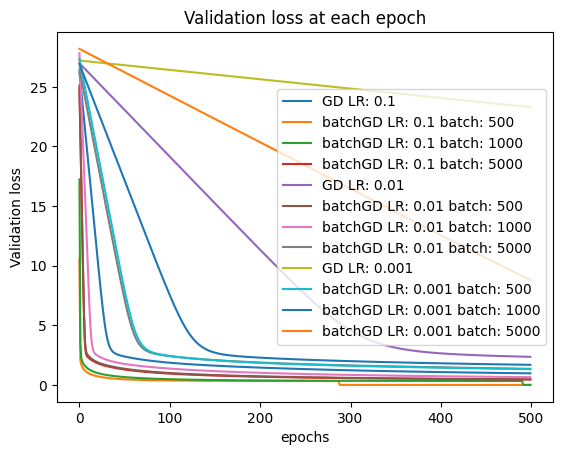

In [52]:
for name, values in results.items():    
    plt.plot(values[1], label=name)
plt.xlabel("epochs")
plt.ylabel("Validation loss")
plt.legend()
plt.title("Validation loss at each epoch")
plt.savefig("Validation_loss_1.png",bbox_inches='tight', dpi=300)

In [94]:
for name, values in results.items():   
    predictions = values[3]
    print(name)
    roc, fpr, tpr = roc_auc_classification(imdb_valid_Y, predictions)
    print("Validation roc auc score:", roc)
    predictions[predictions<0.5] = 0
    predictions[predictions>=0.5] = 1
    print("Validation acc:", evaluate_acc(predictions, imdb_valid_Y))
    print()      

GD LR: 0.1
Validation roc auc score: 0.72832
Validation acc: 0.72832

batchGD LR: 0.1 batch: 500
Validation roc auc score: 0.8652000000000002
Validation acc: 0.8652

batchGD LR: 0.1 batch: 1000
Validation roc auc score: 0.86416
Validation acc: 0.86416

batchGD LR: 0.1 batch: 5000
Validation roc auc score: 0.82576
Validation acc: 0.82576

GD LR: 0.01
Validation roc auc score: 0.57712
Validation acc: 0.57712

batchGD LR: 0.01 batch: 500
Validation roc auc score: 0.82736
Validation acc: 0.82736

batchGD LR: 0.01 batch: 1000
Validation roc auc score: 0.78784
Validation acc: 0.78784

batchGD LR: 0.01 batch: 5000
Validation roc auc score: 0.67504
Validation acc: 0.67504

GD LR: 0.001
Validation roc auc score: 0.5
Validation acc: 0.5

batchGD LR: 0.001 batch: 500
Validation roc auc score: 0.67376
Validation acc: 0.67376

batchGD LR: 0.001 batch: 1000
Validation roc auc score: 0.63696
Validation acc: 0.63696

batchGD LR: 0.001 batch: 5000
Validation roc auc score: 0.50096
Validation acc: 0.500

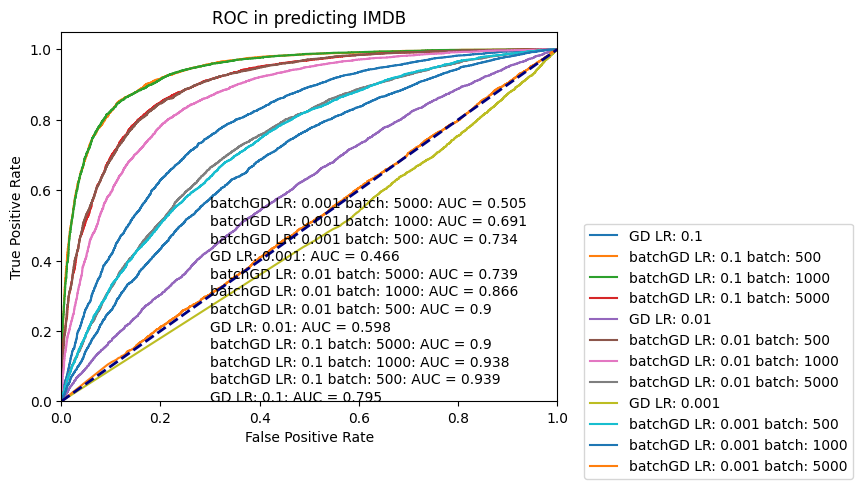

In [56]:
i=0
for name, values in results.items():    
    roc, fpr, tpr = roc_auc_classification(imdb_valid_Y, values[3])
    plt.plot(fpr, tpr, label=name)
    plt.text(0.3, i, name + ': AUC = '+ str(round(roc,3)))
    i+=0.05
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title('ROC in predicting IMDB')
plt.legend(bbox_to_anchor=(1.04, 0.5), loc="upper left")
plt.savefig("ROC_1.png",bbox_inches='tight', dpi=300)

Now that we tested GD and minibatch GD with different learning rates and batch sizes we will keep the analysis using SGD lr=0.1 and batch size =500

In [68]:
momentum=[0.9,0.5,0.1]
RMS=[0.9, 0.5, 0.1]

In [83]:
# Step 1: Initialize a Logistic Regression Class
logistic_regression = LogisticRegression()
# Step 2: Train the model: 
# In the second step we will use lr=0.1 and batch size =500 to compare
# SGD using different momentum #[0.9, 0.5 and 0.1] 
# and AdaGrad with #[0.9, 0.5 and 0.1]
# In total we have 7 combination
# We will use only 500 iteration and early stopping based on the last 10 loss values of validation set
# Based on validation performance, validation loss and training time we will select the best combination of the best method and retrain it.
results2 = dict()
for m in momentum:
    optimizer_batchGD = StochasticGradientDescent(learning_rate=0.1, momentum=m, max_iters=500, minibatch_size = 500, record_history=True, verbose = True)
    start = time.time()
    logistic_regression.fit(imdb_train_X, imdb_train_Y, optimizer=optimizer_batchGD, X_valid=imdb_valid_X, y_valid=imdb_valid_Y,
                                        early_stopping=True, look_back=10)
    time_training = time.time() - start
    print('Training using batchGD for momentum %s ended in %s h %s m %s s\n' % (str(m), time_training // 3600, (time_training % 3600) // 60, time_training % 60))
    results2["batchGD momentum: %s"%str(m)] = [logistic_regression.losses_train, logistic_regression.losses_valid,
                                logistic_regression.w, logistic_regression.predict(imdb_valid_X), time_training, 
                                    logistic_regression.check_grad(imdb_train_X, imdb_train_Y)]
for r in RMS:           
    optimizer_AdaGrad = AdaGrad(learning_rate=0.1, RMSprop=r, max_iters=500, minibatch_size = 500, record_history=True, verbose = True)
    start = time.time()
    logistic_regression.fit(imdb_train_X, imdb_train_Y, optimizer=optimizer_AdaGrad, X_valid=imdb_valid_X, y_valid=imdb_valid_Y,
                                        early_stopping=True, look_back=10)
    time_training = time.time() - start
    print('Training using AdaGrad for RMSprop %s ended in %s h %s m %s s\n' % (str(r),
                                                                       time_training // 3600, (time_training % 3600) // 60, time_training % 60))
    results2["AdaGrad RMSprop: %s"%str(r)] = [logistic_regression.losses_train, logistic_regression.losses_valid,
                                logistic_regression.w, logistic_regression.predict(imdb_valid_X), time_training,
                                                           logistic_regression.check_grad(imdb_train_X, imdb_train_Y)]



epoch 1: 14.280; 14.187
epoch 100: 0.334; 0.390
epoch 200: 0.273; 0.337
Early stopping at epoch 294 due to increase in validation loss.
terminated after 294 epochs, with norm of the gradient equal to 0.08128388954706006
Training using batchGD for momentum 0.9 ended in 0.0 h 7.0 m 58.86787223815918 s

epoch 1: 11.512; 11.412
epoch 100: 0.319; 0.372
epoch 200: 0.266; 0.329
Early stopping at epoch 277 due to increase in validation loss.
terminated after 277 epochs, with norm of the gradient equal to 0.1273181160329722
Training using batchGD for momentum 0.5 ended in 0.0 h 7.0 m 38.27432298660278 s

epoch 1: 11.341; 11.419
epoch 100: 0.311; 0.367
epoch 200: 0.263; 0.328
Early stopping at epoch 269 due to increase in validation loss.
terminated after 269 epochs, with norm of the gradient equal to 0.15081901282245386
Training using batchGD for momentum 0.1 ended in 0.0 h 7.0 m 0.10046148300170898 s

epoch 1: 1.368; 1.422
Early stopping at epoch 12 due to increase in validation loss.
terminat

In [90]:
# save the results in a dict
with open(os.path.join(results_imdb_path, "results1.pickle"), 'wb') as f:
    pickle.dump(results2, f)

In [32]:
with open(os.path.join(results_imdb_path, "results1.pickle"), 'rb') as f:
    results2 = pickle.load(f)

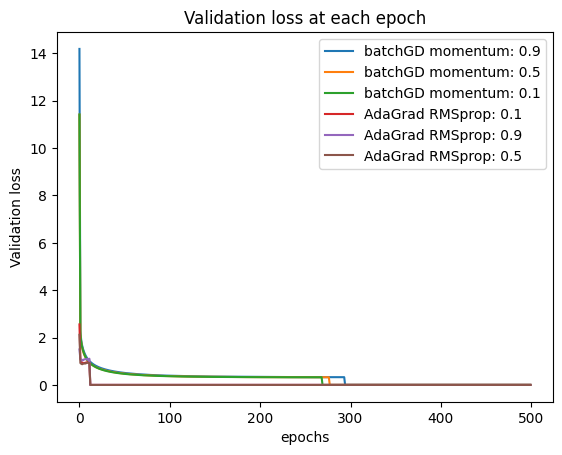

In [91]:
for name, values in results2.items():    
    plt.plot(values[1], label=name)
plt.xlabel("epochs")
plt.ylabel("Validation loss")
plt.legend()
plt.title("Validation loss at each epoch")
plt.savefig("Validation_loss_2.png",bbox_inches='tight', dpi=300)

In [92]:
for name, values in results2.items():   
    predictions = values[3]
    print(name)
    roc, fpr, tpr = roc_auc_classification(imdb_valid_Y, predictions)
    print("Validation roc auc score:", roc)
    predictions[predictions<0.5] = 0
    predictions[predictions>=0.5] = 1
    print("Validation acc:", evaluate_acc(predictions, imdb_valid_Y))
    print()      

batchGD momentum: 0.9
Validation roc auc score: 0.9384210432
Validation acc: 0.86512

batchGD momentum: 0.5
Validation roc auc score: 0.9393965056
Validation acc: 0.8688

batchGD momentum: 0.1
Validation roc auc score: 0.9394447872
Validation acc: 0.8684

AdaGrad RMSprop: 0.1
Validation roc auc score: 0.9270066432000001
Validation acc: 0.84272

AdaGrad RMSprop: 0.9
Validation roc auc score: 0.9286019583999999
Validation acc: 0.8428

AdaGrad RMSprop: 0.5
Validation roc auc score: 0.9244794368000001
Validation acc: 0.83696



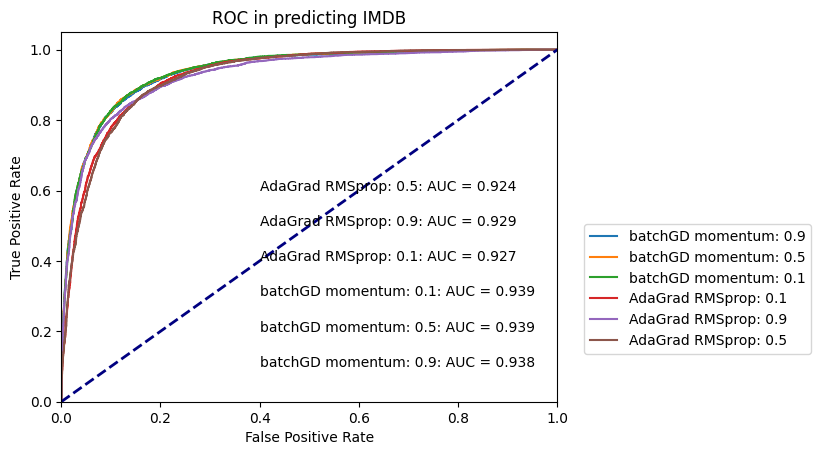

In [33]:
i=0
for name, values in results2.items():    
    roc, fpr, tpr = roc_auc_classification(imdb_valid_Y, values[3])
    plt.plot(fpr, tpr, label=name)
    plt.text(0.4, i+0.1, name + ': AUC = '+ str(round(roc,3)))
    i+=0.1
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title('ROC in predicting IMDB')
plt.legend(bbox_to_anchor=(1.04, 0.5), loc="upper left")
plt.savefig("ROC_2.png",bbox_inches='tight', dpi=300)

In [43]:
# Step 1: Initialize a Logistic Regression Class
logistic_regression = LogisticRegression()
# Step 2: Train the model: 
# In the third step we will use lr=0.1 and batch size =500, momentum= and RMSprop= from above to test ADAM
# SGD using different momentum #[0.9, 0.5 and 0.1] 
# We will use only 500 iteration and early stopping based on the last 10 loss values of validation set
# Based on validation performance, validation loss and training time we will select the best combination of the best method and retrain it.
optimizer_ADAM = ADAM(learning_rate=0.1, momentum=0.1, RMSprop=0.9, max_iters=500, minibatch_size = 500, record_history=True, verbose = True)
start = time.time()
logistic_regression.fit(imdb_train_X, imdb_train_Y, optimizer=optimizer_ADAM, X_valid=imdb_valid_X, y_valid=imdb_valid_Y,
                                    early_stopping=True, look_back=10)
time_training = time.time() - start
print('Training using ADAM ended in %s h %s m %s s\n' % (time_training // 3600, (time_training % 3600) // 60, time_training % 60))
results2["ADAM"] = [logistic_regression.losses_train, logistic_regression.losses_valid,
                            logistic_regression.w, logistic_regression.predict(imdb_valid_X), time_training, 
                                logistic_regression.check_grad(imdb_train_X, imdb_train_Y)]


epoch 1: 2.006; 2.065
Early stopping at epoch 12 due to increase in validation loss.
terminated after 12 epochs, with norm of the gradient equal to 0.9324255114564148
Training using ADAM ended in 0.0 h 0.0 m 16.426730394363403 s



In [44]:
# save the results in a dict
with open(os.path.join(results_imdb_path, "results3.pickle"), 'wb') as f:
    pickle.dump(results2, f)

In [27]:
with open(os.path.join(results_imdb_path, "results3.pickle"), 'rb') as f:
    results2 = pickle.load(f)

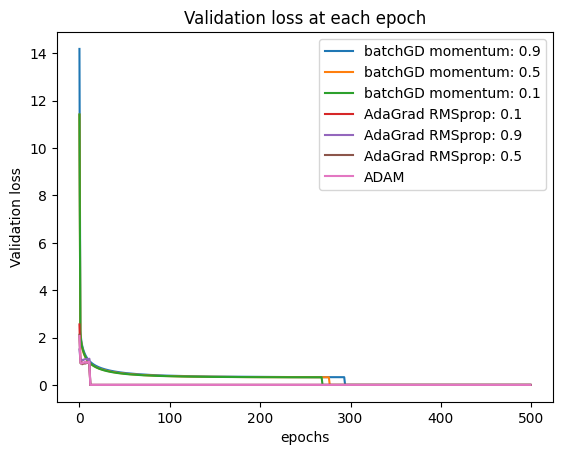

In [45]:
for name, values in results2.items():    
    plt.plot(values[1], label=name)
plt.xlabel("epochs")
plt.ylabel("Validation loss")
plt.legend()
plt.title("Validation loss at each epoch")
plt.savefig("Validation_loss_3.png",bbox_inches='tight', dpi=300)

In [46]:
predictions = results2["ADAM"][3]
print("ADAM")
roc, fpr, tpr = roc_auc_classification(imdb_valid_Y, predictions)
print("Validation roc auc score:", roc)
predictions[predictions<0.5] = 0
predictions[predictions>=0.5] = 1
print("Validation acc:", evaluate_acc(predictions, imdb_valid_Y))
print()      

ADAM
Validation roc auc score: 0.9226007808000001
Validation acc: 0.81328



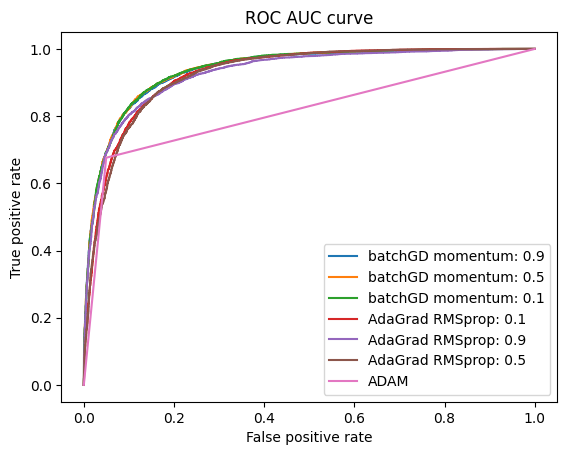

In [47]:
for name, values in results2.items():    
    roc, fpr, tpr = roc_auc_classification(imdb_valid_Y, values[3])

    plt.plot(fpr, tpr, label=name)
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.legend()
plt.title("ROC AUC curve")
plt.savefig("ROC_3.png",bbox_inches='tight', dpi=300)

We will continue the 2nd round of analysis using BatchGradientDescent with 0,1 LR, 500 batch size and 0.1 momentum

Now we will retrain our best model and compare its prediction accuracy on test set to KNN

## Report the binary classification AUROC of logistic regression and KNN on the IMDB data

In [9]:
#we will select best k using validation set
for k in range(1, 11):
    print("k:", k)
    knn_weighted = kNN(n_neighbors=k, weights='distance')
    knn_weighted.fit(imdb_train_X, imdb_train_Y)
    preds=knn_weighted.predict_proba(imdb_valid_X)
    roc, fpr, tpr = roc_auc_classification(imdb_valid_Y, preds[:,1:])
    print("Validation roc auc score for weighted k= %s:"%k, roc)
    preds=knn_weighted.predict(imdb_valid_X)
    print("Validation accfor weighted k= %s:"%k, evaluate_acc(preds, imdb_valid_Y))


k: 1
Validation roc auc score for weighted k= 1: 0.5974400000000001
Validation accfor weighted k= 1: 0.59744
k: 2
Validation roc auc score for weighted k= 2: 0.6360541312
Validation accfor weighted k= 2: 0.59584
k: 3
Validation roc auc score for weighted k= 3: 0.6569476992000001
Validation accfor weighted k= 3: 0.61824
k: 4
Validation roc auc score for weighted k= 4: 0.6678410624
Validation accfor weighted k= 4: 0.61616
k: 5
Validation roc auc score for weighted k= 5: 0.6766198912000001
Validation accfor weighted k= 5: 0.62648
k: 6
Validation roc auc score for weighted k= 6: 0.681192896
Validation accfor weighted k= 6: 0.62632
k: 7
Validation roc auc score for weighted k= 7: 0.6872919423999999
Validation accfor weighted k= 7: 0.62632
k: 8
Validation roc auc score for weighted k= 8: 0.6936360832
Validation accfor weighted k= 8: 0.63448
k: 9
Validation roc auc score for weighted k= 9: 0.6990564991999999
Validation accfor weighted k= 9: 0.63304
k: 10
Validation roc auc score for weighted 

In [9]:
#we will select best k using validation set
for k in range(1, 11):
    print("k:", k)
    knn_unweighted = kNN(n_neighbors=k, weights='uniform')
    knn_unweighted.fit(imdb_train_X, imdb_train_Y)
    preds=knn_unweighted.predict_proba(imdb_valid_X)
    roc, fpr, tpr = roc_auc_classification(imdb_valid_Y, preds[:,1:])
    print("Validation roc auc score for unweighted k= %s:"%k, roc)
    preds=knn_unweighted.predict(imdb_valid_X)
    print("Validation accfor unweighted k= %s:"%k, evaluate_acc(preds, imdb_valid_Y))


k: 1
Validation roc auc score for unweighted k= 1: 0.5974400000000001
Validation accfor unweighted k= 1: 0.59744
k: 2
Validation roc auc score for unweighted k= 2: 0.6328459775999999
Validation accfor unweighted k= 2: 0.5964
k: 3
Validation roc auc score for unweighted k= 3: 0.6516967936
Validation accfor unweighted k= 3: 0.61744
k: 4
Validation roc auc score for unweighted k= 4: 0.6603920768
Validation accfor unweighted k= 4: 0.61
k: 5
Validation roc auc score for unweighted k= 5: 0.6696188928
Validation accfor unweighted k= 5: 0.62488
k: 6
Validation roc auc score for unweighted k= 6: 0.6735035904
Validation accfor unweighted k= 6: 0.62104
k: 7
Validation roc auc score for unweighted k= 7: 0.6801675904
Validation accfor unweighted k= 7: 0.6244
k: 8
Validation roc auc score for unweighted k= 8: 0.6872644224
Validation accfor unweighted k= 8: 0.62432
k: 9
Validation roc auc score for unweighted k= 9: 0.693035136
Validation accfor unweighted k= 9: 0.63104
k: 10
Validation roc auc score 

In [30]:
# we will use weighted knn with k=10 and compare to our selected model from abode using the test set

In [47]:
logistic_regression=LogisticRegression()
optimizer_batchGD = StochasticGradientDescent(learning_rate=0.1, momentum=0.1, max_iters=300, minibatch_size = 500, record_history=True, verbose = True)
logistic_regression.fit(imdb_train_X, imdb_train_Y, optimizer=optimizer_batchGD, X_valid=imdb_valid_X, y_valid=imdb_valid_Y,
                                    early_stopping=True, look_back=10)
predictions=logistic_regression.predict(imdb_test_X)
roc, fpr, tpr = roc_auc_classification(imdb_test_Y, predictions)
print("Test roc auc score:", roc)
predictions[predictions<0.5] = 0
predictions[predictions>=0.5] = 1
print("Test acc:", evaluate_acc(predictions, imdb_test_Y))
print()      

epoch 1: 9.857; 9.795
epoch 100: 0.314; 0.374
epoch 200: 0.263; 0.333
epoch 300: 0.251; 0.326
terminated after 301 epochs, with norm of the gradient equal to 0.1235779523975598
Test roc auc score: 0.9373145344
Test acc: 0.86744



In [53]:
knn_weighted = kNN(n_neighbors=10, weights='distance')
knn_weighted.fit(imdb_train_X, imdb_train_Y)
preds=knn_weighted.predict_proba(imdb_test_X)
roc_knn, fpr_knn, tpr_knn = roc_auc_classification(imdb_test_Y, preds[:,1:])
print("Test roc auc score for weighted k= %s:"%10, roc_knn)
preds=knn_weighted.predict(imdb_test_X)
print("Test acc for weighted k= %s:"%10, evaluate_acc(preds, imdb_test_Y))


Test roc auc score for weighted k= 10: 0.7157426816000001
Test acc for weighted k= 10: 0.64872


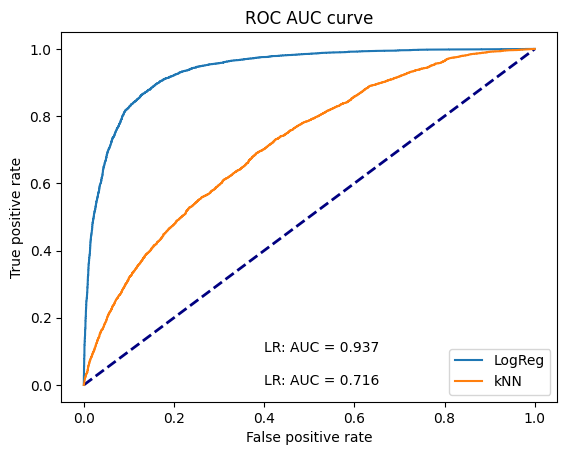

In [52]:
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.plot(fpr, tpr, label='LogReg')
plt.text(0.4, 0.1, 'LR: AUC = '+ str(round(roc,3)))
plt.plot(fpr_knn, tpr_knn, label='kNN')
plt.text(0.4, 0., 'LR: AUC = '+ str(round(roc_knn,3)))

plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.legend()
plt.title("ROC AUC curve")
plt.savefig("ROC_LRKNN.png",bbox_inches='tight', dpi=300)

In [33]:
# performance of LR is way better than KNN

In [57]:
# now we will train using the model from above but with changing the size of training feature based on z-score
# for each iteration we will add 100 more feature having the highest z-score

In [35]:
absolute_z_score=np.load(os.path.join(results_imdb_path, 'absolute_z_score.npy'))
absolute_z_score=absolute_z_score.tolist()

In [48]:
copy_set=copy.deepcopy(absolute_z_score)
max_num=[]
max_index=[]

for _ in range(1000):
    num= max(copy_set)
    index=copy_set.index(num)
    copy_set[index]=0
    max_num.append(num)
    max_index.append(index) # save the indexes of these features with top 200 z-scores
copy_set=[]
# now we have the index of the highest 1000 feature

In [55]:
logistic_regression=LogisticRegression()
optimizer_batchGD = StochasticGradientDescent(learning_rate=0.1, momentum=0.1, max_iters=300, minibatch_size = 500, record_history=True, verbose = True)
results_data=dict()
for i in range(1,11):
    print("Training using %s features"%str(i*100))
    idx_top=max_index[:100*i]
    imdb_test_X[:,max_index].shape
    logistic_regression.fit(imdb_train_X[:,idx_top], imdb_train_Y, optimizer=optimizer_batchGD, X_valid=imdb_valid_X[:,idx_top], y_valid=imdb_valid_Y,
                                    early_stopping=True, look_back=10)
    predictions=logistic_regression.predict(imdb_valid_X[:,idx_top])
    roc, fpr, tpr = roc_auc_classification(imdb_valid_Y, predictions)
    print("Validation roc auc score:", roc)
    predictions[predictions<0.5] = 0
    predictions[predictions>=0.5] = 1
    acc=evaluate_acc(predictions, imdb_valid_Y)
    print("Validation acc:", evaluate_acc(predictions, imdb_valid_Y))
    print()      
    results_data[i*100]=[roc, acc]

Training using 100 features
epoch 1: 1.289; 1.268
epoch 100: 0.555; 0.567
Early stopping at epoch 103 due to increase in validation loss.
terminated after 103 epochs, with norm of the gradient equal to 0.08369579117414258
Validation roc auc score: 0.7829695743999999
Validation acc: 0.71408

Training using 200 features
epoch 1: 1.441; 1.415
epoch 100: 0.535; 0.553
Early stopping at epoch 115 due to increase in validation loss.
terminated after 115 epochs, with norm of the gradient equal to 0.09876762824275141
Validation roc auc score: 0.7979087872000001
Validation acc: 0.7264

Training using 300 features
epoch 1: 1.689; 1.685
epoch 100: 0.513; 0.533
Early stopping at epoch 132 due to increase in validation loss.
terminated after 132 epochs, with norm of the gradient equal to 0.14790792333359168
Validation roc auc score: 0.8138740992
Validation acc: 0.74392

Training using 400 features
epoch 1: 2.621; 2.639
epoch 100: 0.507; 0.534
Early stopping at epoch 152 due to increase in validation

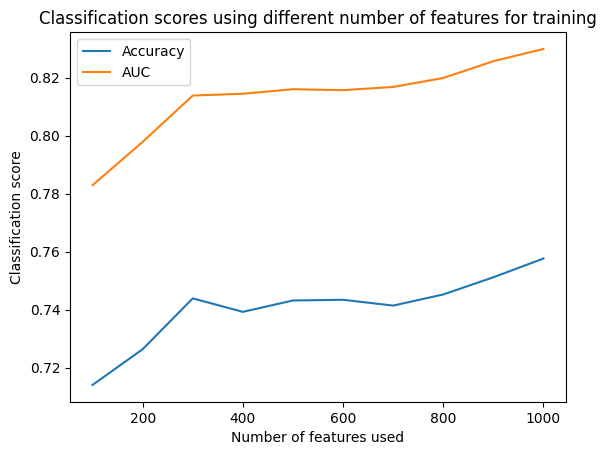

In [64]:
x_label=[100*i for i in range(1,11)]
plt.plot(x_label, [val[1] for val in results_data.values()],  label="Accuracy")
plt.plot(x_label, [val[0] for val in results_data.values()],   label="AUC")

plt.xlabel("Number of features used")
plt.ylabel("Classification score")
plt.legend()
plt.title("Classification scores using different number of features for training")
plt.savefig("data_1.png",bbox_inches='tight', dpi=300)

In [65]:
logistic_regression=LogisticRegression()
optimizer_batchGD = StochasticGradientDescent(learning_rate=0.1, momentum=0.1, max_iters=300, minibatch_size = 500, record_history=True, verbose = True)
logistic_regression.fit(imdb_train_X[:,max_index], imdb_train_Y, optimizer=optimizer_batchGD, X_valid=imdb_valid_X[:,max_index], y_valid=imdb_valid_Y,
                                    early_stopping=True, look_back=10)
predictions=logistic_regression.predict(imdb_test_X[:,max_index])
roc, fpr, tpr = roc_auc_classification(imdb_test_Y, predictions)
print("Test roc auc score:", roc)
predictions[predictions<0.5] = 0
predictions[predictions>=0.5] = 1
print("Test acc:", evaluate_acc(predictions, imdb_test_Y))
print()      

epoch 1: 6.724; 6.516
epoch 100: 0.482; 0.533
Early stopping at epoch 151 due to increase in validation loss.
terminated after 151 epochs, with norm of the gradient equal to 0.25190429273160314
Test roc auc score: 0.836761088
Test acc: 0.76152



In [66]:
# adding more features improves the accuracy and auc, yet using from 100 to 1000 features with highest z-scores 
# didn't give us an accurac better than using the whole features. Now we will test using different variations of train data size

In [71]:
shuffled_indices = np.asanyarray(range(imdb_train_X.shape[0])) 
random.shuffle(shuffled_indices)    # new shuffled indices
imdb_train_X_shuffled = imdb_train_X[shuffled_indices]
imdb_train_Y_shuffled = imdb_train_Y[shuffled_indices]

In [72]:
logistic_regression=LogisticRegression()
optimizer_batchGD = StochasticGradientDescent(learning_rate=0.1, momentum=0.1, max_iters=1000, minibatch_size = 500, record_history=True, verbose = True)
knn_weighted = kNN(n_neighbors=10, weights='distance')
results_data=dict()
for i in range(1,6):
    print("Training using %s training simple"%str(i*5000))
    logistic_regression.fit(imdb_train_X_shuffled[:i*5000], imdb_train_Y_shuffled[:i*5000], optimizer=optimizer_batchGD, X_valid=imdb_valid_X, y_valid=imdb_valid_Y,
                                    early_stopping=True, look_back=10)
    predictions=logistic_regression.predict(imdb_valid_X)
    roc, fpr, tpr = roc_auc_classification(imdb_valid_Y, predictions)
    print("LR Validation roc auc score:", roc)
    predictions[predictions<0.5] = 0
    predictions[predictions>=0.5] = 1
    acc=evaluate_acc(predictions, imdb_valid_Y)
    print("LR Validation acc:", evaluate_acc(predictions, imdb_valid_Y))
    print()      
    knn_weighted.fit(imdb_train_X_shuffled[:i*5000], imdb_train_Y_shuffled[:i*5000])
    preds=knn_weighted.predict_proba(imdb_valid_X)
    roc_knn, fpr_knn, tpr_knn = roc_auc_classification(imdb_valid_Y, preds[:,1:])
    print("Test roc auc score for weighted k= %s:"%10, roc_knn)
    preds=knn_weighted.predict(imdb_test_X)
    accKNN=evaluate_acc(preds, imdb_valid_Y)

    print("Test acc for weighted k= %s:"%10, accKNN)
    results_data[i*5000]=[roc, acc, roc_knn, accKNN]


Training using 5000 training simple
epoch 1: 24.481; 23.842
epoch 100: 0.523; 0.813
epoch 200: 0.324; 0.649
epoch 300: 0.249; 0.587
epoch 400: 0.210; 0.557
epoch 500: 0.185; 0.542
Early stopping at epoch 565 due to increase in validation loss.
terminated after 565 epochs, with norm of the gradient equal to 0.09328604895585205
LR Validation roc auc score: 0.895537536
LR Validation acc: 0.81864

Test roc auc score for weighted k= 10: 0.6544830848000001
Test acc for weighted k= 10: 0.60576
Training using 10000 training simple
epoch 1: 18.957; 18.543
epoch 100: 0.419; 0.555
epoch 200: 0.293; 0.446
epoch 300: 0.248; 0.414
epoch 400: 0.225; 0.402
Early stopping at epoch 475 due to increase in validation loss.
terminated after 475 epochs, with norm of the gradient equal to 0.1190190679211047
LR Validation roc auc score: 0.9220694016000001
LR Validation acc: 0.84824

Test roc auc score for weighted k= 10: 0.6850266368000001
Test acc for weighted k= 10: 0.63472
Training using 15000 training sim

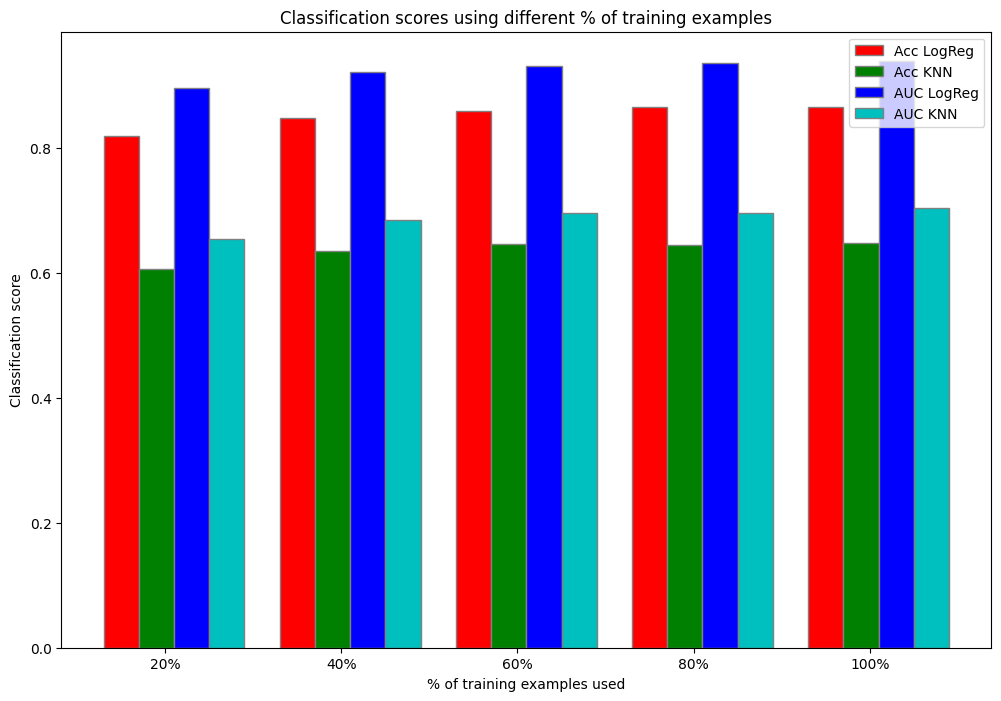

<Figure size 640x480 with 0 Axes>

In [73]:
# set width of bar
barWidth = 0.20
fig = plt.subplots(figsize =(12, 8))

# set height of bar
accLR = [val[1] for val in results_data.values()]
accKNN = [val[3] for val in results_data.values()]
aucLR = [val[0] for val in results_data.values()]
aucKNN = [val[2] for val in results_data.values()]

# Set position of bar on X axis
br1 = np.arange(len(accLR))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
br4 = [x + barWidth for x in br3]

# Make the plot
plt.bar(br1, accLR, color ='r', width = barWidth, edgecolor ='grey', label ='Acc LogReg')
plt.bar(br2, accKNN, color ='g', width = barWidth, edgecolor ='grey', label ='Acc KNN')
plt.bar(br3, aucLR, color ='b', width = barWidth, edgecolor ='grey', label ='AUC LogReg')
plt.bar(br4, aucKNN, color ='c', width = barWidth, edgecolor ='grey', label ='AUC KNN')

# Adding Xticks
plt.xticks([r + barWidth +0.05 for r in range(len(accLR))], ['20%', '40%', '60%', '80%', '100%'])
plt.xlabel("% of training examples used")
plt.ylabel("Classification score")
plt.title("Classification scores using different % of training examples")

plt.legend()
plt.show()
plt.savefig("data_2.png",bbox_inches='tight', dpi=300)

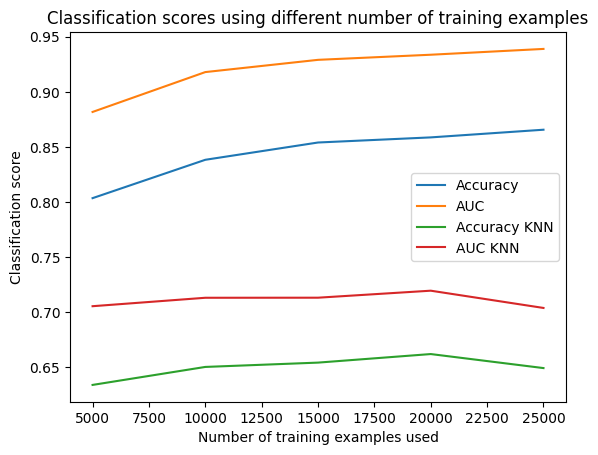

In [58]:
x_label=[5000*i for i in range(1,6)]
plt.plot(x_label, [val[1] for val in results_data.values()],  label="Accuracy")
plt.plot(x_label, [val[0] for val in results_data.values()],   label="AUC")
plt.plot(x_label, [val[3] for val in results_data.values()],  label="Accuracy KNN")
plt.plot(x_label, [val[2] for val in results_data.values()],   label="AUC KNN")

plt.xlabel("Number of training examples used")
plt.ylabel("Classification score")
plt.legend()
plt.title("Classification scores using different number of training examples")
plt.savefig("data_2.png",bbox_inches='tight', dpi=300)

In [44]:
logistic_regression=LogisticRegression()
optimizer_batchGD = StochasticGradientDescent(learning_rate=0.1, momentum=0.1, max_iters=300, minibatch_size = 500, record_history=True, verbose = True)
logistic_regression.fit(imdb_train_X, imdb_train_Y, optimizer=optimizer_batchGD, X_valid=imdb_valid_X, y_valid=imdb_valid_Y,
                                    early_stopping=True, look_back=10)
predictions=logistic_regression.predict(imdb_test_X)
roc, fpr, tpr = roc_auc_classification(imdb_test_Y, predictions)
print("Test roc auc score:", roc)
predictions[predictions<0.5] = 0
predictions[predictions>=0.5] = 1
print("Test acc:", evaluate_acc(predictions, imdb_test_Y))
print()      

epoch 1: 10.556; 10.508
epoch 100: 0.313; 0.376
epoch 200: 0.263; 0.334
Early stopping at epoch 298 due to increase in validation loss.
terminated after 298 epochs, with norm of the gradient equal to 0.144256070474949
Test roc auc score: 0.9369495552000001
Test acc: 0.86816



In [60]:
feat=[]
for l in [max_index[:10], min_index[:10]]:
    for idx in l:
        feat.append(idx)
names=[]
for l in [vocab_max_z[:10], vocab_min_z[:10]]:
    for idx in l:
        names.append(idx)


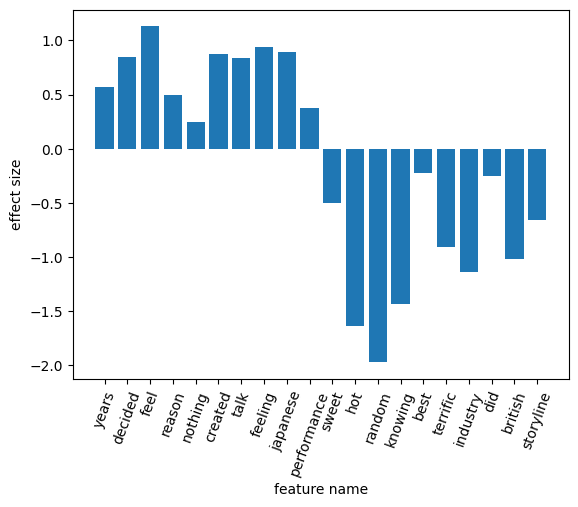

In [65]:
plt.bar(names, list(logistic_regression.w[feat]))
plt.ylabel("effect size")
plt.xlabel("feature name")
plt.xticks(rotation = 70) # Rotates X-Axis Ticks by 45-degrees
# plt.show()
plt.savefig("effect_size.png", bbox_inches='tight', dpi=300)


## Predicting rating using LR


In [24]:
imdb_train_X = np.load(r'selected-feature-list.npy')
imdb_train_Y = np.load(r'label_train.npy')
imdb_train_X = imdb_train_X.T
imdb_train_Y = imdb_train_Y.astype(int) # make sure we have integer scores

In [25]:
imdb_test_X = np.load(r'selected-feature-list-test.npy')
imdb_test_Y = np.load(r'label_test.npy')
imdb_test_X = imdb_test_X.T
imdb_test_Y = imdb_test_Y.astype(int) # make sure we have integer scores

In [41]:
LogisReg.fit(imdb_train_X, imdb_train_Y, gd=False)

In [42]:
preds=LogisReg.predict(imdb_test_X)

In [43]:
from sklearn.metrics import r2_score
r2=r2_score(imdb_test_Y, preds)
r2

-0.14448815941272075

### (b) Multi-class classification on the 20 news group dataset

In [101]:
#we will use the selected data with 288 feature
X_valid_selected_20news=X_test_selected_20news[791:]
X_test_selected_20news=X_test_selected_20news[:791]


In [95]:
Y_valid_20news=Y_test_20news[791:]
Y_test_20news=Y_test_20news[:791]


In [108]:
LR=[0.1,0.01,0.001]
batch_size=[32, 64, 128, ]

In [110]:
# Step 1: Initialize a Multinomial Regression Class
multiclass_regression = Multinomial_logistic()
# Step 2: Train the model: 
# In a first step we will start by training LR using different methods X Learning rates:
# For all the method we will test 3 learning rates: .1, .01 and .001
# The methods are : GradientDescent (3 combinations); and BatchGradientDescent 
# For Batch GD we will test 3 batch sizes per LR: [100,1000,5000] ==> 9 Combinations
# In total we have 15 combination
# We will use only 500 iteration and early stopping based on the last 10 loss values of validation set
# Based on validation performance, validation loss and training time we will select the best combination of the best method and retrain it.
results = dict()
for lr in LR:
    optimizer_GD = GradientDescent(learning_rate=lr, max_iters=1000, record_history=True, verbose = True)
    start = time.time()
    multiclass_regression.fit(X_train_selected_20news, Y_train_20news, optimizer=optimizer_GD, X_valid=X_valid_selected_20news, 
                              y_valid=Y_valid_20news, early_stopping=False, look_back=100)
    time_training = time.time() - start
    print('Training using GD for LR %s ended in %s h %s m %s s\n' % (str(lr), time_training // 3600, (time_training % 3600) // 60, time_training % 60))
    results["GD LR: %s"%str(lr)] = [multiclass_regression.losses_train, multiclass_regression.losses_valid,
                                multiclass_regression.w, multiclass_regression.predict(X_valid_selected_20news, multiclass_regression.w), time_training, 
                                    multiclass_regression.check_grad(X_train_selected_20news, Y_train_20news)
                                   ]
    for batch in batch_size:           
        optimizer_batchGD = StochasticGradientDescent(learning_rate=lr, max_iters=1000, record_history=True, minibatch_size = batch, verbose = True)
        start = time.time()
        multiclass_regression.fit(X_train_selected_20news, Y_train_20news, optimizer=optimizer_batchGD, X_valid=X_valid_selected_20news,
                                y_valid=Y_valid_20news,  early_stopping=False, look_back=10)
        time_training = time.time() - start
        print('Training using batchGD for LR %s and batch size: %s ended in %s h %s m %s s\n' % (str(lr), str(batch),
                                                                           time_training // 3600, (time_training % 3600) // 60, time_training % 60))
        results["batchGD LR: %s batch: %s"%(str(lr), batch)] = [multiclass_regression.losses_train, multiclass_regression.losses_valid,
                                multiclass_regression.w, multiclass_regression.predict(X_valid_selected_20news, multiclass_regression.w), time_training, 
                                    multiclass_regression.check_grad(X_train_selected_20news, Y_train_20news)
                                   ]


/tmp/ipykernel_61336/3723332841.py:28: RuntimeWarning: overflow encountered in exp
  y_pred = np.exp(np.matmul(X, w))
/tmp/ipykernel_61336/3723332841.py:29: RuntimeWarning: invalid value encountered in divide
  return y_pred / y_pred.sum(axis=1).reshape(X.shape[0], 1)
/tmp/ipykernel_61336/3723332841.py:10: RuntimeWarning: divide by zero encountered in log
  return -np.mean(y * np.log(self.predict(X, w))) #changed to mean not sum
/tmp/ipykernel_61336/3723332841.py:10: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(y * np.log(self.predict(X, w))) #changed to mean not sum


epoch 1: nan; nan

terminated after 3 epochs, with norm of the gradient equal to nan
Training using GD for LR 0.1 ended in 0.0 h 0.0 m 0.06923460960388184 s

epoch 1: 0.307; 0.356
epoch 100: 0.258; 0.333
epoch 200: 0.256; 0.343
epoch 300: 0.259; 0.348
epoch 400: 0.256; 0.351
epoch 500: 0.257; 0.352
epoch 600: 0.256; 0.358
epoch 700: 0.257; 0.359
epoch 800: 0.256; 0.360
epoch 900: 0.255; 0.361
epoch 1000: 0.256; 0.364
terminated after 1001 epochs, with norm of the gradient equal to 6.114668499748424
Training using batchGD for LR 0.1 and batch size: 32 ended in 0.0 h 2.0 m 59.90669012069702 s



/tmp/ipykernel_61336/3723332841.py:53: RuntimeWarning: invalid value encountered in double_scalars
  diff[i, j] = np.square(derived_grad - numeric_grad).sum() / \


epoch 1: 0.330; 0.372
epoch 100: 0.261; 0.338
epoch 200: 0.261; 0.352
epoch 300: 0.271; 0.364
epoch 400: 0.259; 0.353
epoch 500: 0.261; 0.359
epoch 600: 0.259; 0.359
epoch 700: 0.258; 0.360
epoch 800: 0.260; 0.366
epoch 900: 0.259; 0.365
epoch 1000: 0.259; 0.367
terminated after 1001 epochs, with norm of the gradient equal to 5.003558241839614
Training using batchGD for LR 0.1 and batch size: 64 ended in 0.0 h 1.0 m 47.68078684806824 s

epoch 1: 0.377; 0.465
epoch 100: 0.267; 0.351
epoch 200: 0.269; 0.362
epoch 300: 0.278; 0.378
epoch 400: 0.269; 0.376
epoch 500: 0.267; 0.374
epoch 600: 0.268; 0.381
epoch 700: 0.270; 0.382
epoch 800: 0.266; 0.381
epoch 900: 0.269; 0.389
epoch 1000: 0.267; 0.386
terminated after 1001 epochs, with norm of the gradient equal to 13.351708383580137
Training using batchGD for LR 0.1 and batch size: 128 ended in 0.0 h 1.0 m 4.913635492324829 s

epoch 1: 0.534; 0.617
epoch 100: 0.366; 0.469
epoch 200: 0.358; 0.474
epoch 300: 0.390; 0.490
epoch 400: 0.371; 0.47

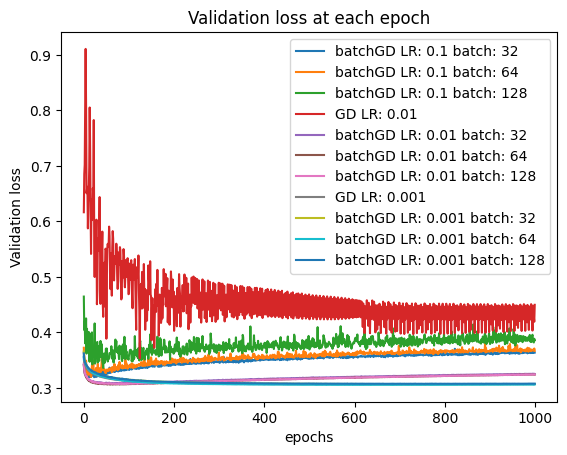

In [181]:
for name, values in results.items(): 
    if name =="GD LR: 0.1":
        continue
    plt.plot(values[1], label=name)
plt.xlabel("epochs")
plt.ylabel("Validation loss")
plt.legend()
plt.title("Validation loss at each epoch")
plt.savefig("Validation_loss_4.png",bbox_inches='tight', dpi=300)

In [123]:
for name, values in results.items():   
    print(name)
    predictions = values[3]
    print("Validation acc: %s "%str(round(evaluate_multiclass(predictions, Y_valid_20news)*100,3)))
    print()      

GD LR: 0.1
Validation acc: 25.664 

batchGD LR: 0.1 batch: 32
Validation acc: 38.053 

batchGD LR: 0.1 batch: 64
Validation acc: 38.812 

batchGD LR: 0.1 batch: 128
Validation acc: 35.398 

GD LR: 0.01
Validation acc: 37.295 

batchGD LR: 0.01 batch: 32
Validation acc: 38.938 

batchGD LR: 0.01 batch: 64
Validation acc: 38.938 

batchGD LR: 0.01 batch: 128
Validation acc: 38.938 

GD LR: 0.001
Validation acc: 38.812 

batchGD LR: 0.001 batch: 32
Validation acc: 38.938 

batchGD LR: 0.001 batch: 64
Validation acc: 38.812 

batchGD LR: 0.001 batch: 128
Validation acc: 38.559 



In [148]:
# Using Gradient descent makes loss not stable and fluctuate, the best results we got was for LR=0.01 and batch=128
# now we test effect of momentum

In [125]:
momentum=[0.9,0.5,0.1]
RMS=[0.9, 0.5, 0.1]

In [149]:
# Step 1: Initialize a Multinomial Regression Class
multiclass_regression = Multinomial_logistic()
# Step 2: Train the model: 
# In the second step we will use lr=0.1 and batch size =500 to compare
# SGD using different momentum #[0.9, 0.5 and 0.1] 
# and AdaGrad with #[0.9, 0.5 and 0.1]
# In total we have 7 combination
# We will use only 500 iteration and early stopping based on the last 10 loss values of validation set
# Based on validation performance, validation loss and training time we will select the best combination of the best method and retrain it.
results2 = dict()
for m in momentum:
    optimizer_batchGD = StochasticGradientDescent(learning_rate=0.01, momentum=m, max_iters=1000, minibatch_size = 128, record_history=True, verbose = True)
    start = time.time()
    multiclass_regression.fit(X_train_selected_20news, Y_train_20news, optimizer=optimizer_batchGD, X_valid=X_valid_selected_20news,
                                y_valid=Y_valid_20news,  early_stopping=False, look_back=10)
    time_training = time.time() - start
    print('Training using batchGD for momentum %s ended in %s h %s m %s s\n' % (str(m), time_training // 3600, (time_training % 3600) // 60, time_training % 60))
    results2["batchGD momentum: %s"%str(m)] = [multiclass_regression.losses_train, multiclass_regression.losses_valid,
                                multiclass_regression.w, multiclass_regression.predict(X_valid_selected_20news, multiclass_regression.w), time_training, 
                                    multiclass_regression.check_grad(X_train_selected_20news, Y_train_20news)
                                   ]
for r in RMS:           
    optimizer_AdaGrad = AdaGrad(learning_rate=0.1, RMSprop=r, max_iters=1000, minibatch_size = 500, record_history=True, verbose = True)
    start = time.time()
    multiclass_regression.fit(X_train_selected_20news, Y_train_20news, optimizer=optimizer_AdaGrad, X_valid=X_valid_selected_20news,
                                y_valid=Y_valid_20news,  early_stopping=False, look_back=10)
    time_training = time.time() - start
    print('Training using AdaGrad for RMSprop %s ended in %s h %s m %s s\n' % (str(r),
                                                                       time_training // 3600, (time_training % 3600) // 60, time_training % 60))
    results2["AdaGrad RMSprop: %s"%str(r)] = [multiclass_regression.losses_train, multiclass_regression.losses_valid,
                                multiclass_regression.w, multiclass_regression.predict(X_valid_selected_20news, multiclass_regression.w), time_training, 
                                    multiclass_regression.check_grad(X_train_selected_20news, Y_train_20news)
                                   ]


epoch 1: 0.348; 0.357
epoch 100: 0.283; 0.307
epoch 200: 0.276; 0.308
epoch 300: 0.274; 0.309
epoch 400: 0.272; 0.310
epoch 500: 0.270; 0.312
epoch 600: 0.269; 0.313
epoch 700: 0.268; 0.314
epoch 800: 0.268; 0.316
epoch 900: 0.266; 0.317
epoch 1000: 0.267; 0.318
terminated after 1001 epochs, with norm of the gradient equal to 0.8961820184758774
Training using batchGD for momentum 0.9 ended in 0.0 h 1.0 m 11.347048044204712 s



/tmp/ipykernel_61336/3723332841.py:53: RuntimeWarning: invalid value encountered in double_scalars
  diff[i, j] = np.square(derived_grad - numeric_grad).sum() / \


epoch 1: 0.332; 0.345
epoch 100: 0.277; 0.306
epoch 200: 0.272; 0.308
epoch 300: 0.269; 0.310
epoch 400: 0.268; 0.313
epoch 500: 0.266; 0.316
epoch 600: 0.266; 0.317
epoch 700: 0.265; 0.319
epoch 800: 0.265; 0.320
epoch 900: 0.265; 0.321
epoch 1000: 0.265; 0.322
terminated after 1001 epochs, with norm of the gradient equal to 3.3010109607918143
Training using batchGD for momentum 0.5 ended in 0.0 h 1.0 m 18.143643856048584 s

epoch 1: 0.336; 0.349
epoch 100: 0.276; 0.309
epoch 200: 0.272; 0.310
epoch 300: 0.269; 0.313
epoch 400: 0.267; 0.315
epoch 500: 0.267; 0.317
epoch 600: 0.266; 0.320
epoch 700: 0.265; 0.321
epoch 800: 0.265; 0.322
epoch 900: 0.265; 0.324
epoch 1000: 0.264; 0.325
terminated after 1001 epochs, with norm of the gradient equal to 10.339650900800754
Training using batchGD for momentum 0.1 ended in 0.0 h 1.0 m 14.468295097351074 s

epoch 1: 0.296; 0.319
epoch 100: 0.266; 0.451
epoch 200: 0.271; 0.459
epoch 300: 0.273; 0.466


/tmp/ipykernel_61336/3723332841.py:10: RuntimeWarning: divide by zero encountered in log
  return -np.mean(y * np.log(self.predict(X, w))) #changed to mean not sum
/tmp/ipykernel_61336/3723332841.py:10: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(y * np.log(self.predict(X, w))) #changed to mean not sum


epoch 400: nan; nan
epoch 500: nan; nan


/tmp/ipykernel_61336/3723332841.py:29: RuntimeWarning: invalid value encountered in divide
  return y_pred / y_pred.sum(axis=1).reshape(X.shape[0], 1)


terminated after 510 epochs, with norm of the gradient equal to nan
Training using AdaGrad for RMSprop 0.9 ended in 0.0 h 0.0 m 17.172164916992188 s

epoch 1: 0.322; 0.332
epoch 100: 0.271; 0.442
epoch 200: 0.275; 0.459
epoch 300: 0.266; 0.466
epoch 400: 0.274; 0.472
epoch 500: 0.268; 0.472
epoch 600: nan; nan
epoch 700: 0.272; nan
epoch 800: 0.273; nan
terminated after 872 epochs, with norm of the gradient equal to nan
Training using AdaGrad for RMSprop 0.5 ended in 0.0 h 0.0 m 31.824129819869995 s

epoch 1: 0.324; 0.338
epoch 100: 0.273; 0.435
epoch 200: 0.273; 0.456
epoch 300: 0.273; 0.469
epoch 400: 0.271; 0.469
epoch 500: 0.272; 0.471
epoch 600: nan; nan
epoch 700: nan; nan
epoch 800: 0.270; nan
epoch 900: 0.274; nan
terminated after 904 epochs, with norm of the gradient equal to nan
Training using AdaGrad for RMSprop 0.1 ended in 0.0 h 0.0 m 36.63186311721802 s



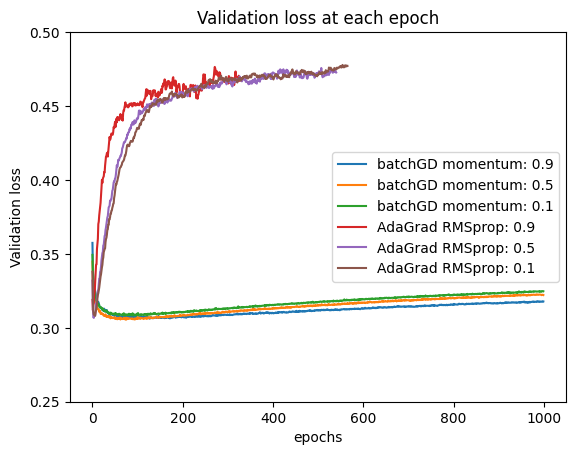

In [152]:
for name, values in results2.items():    
    plt.plot(values[1], label=name)
plt.xlabel("epochs")
plt.ylabel("Validation loss")
plt.ylim([0.25, 0.5])
plt.legend()
plt.title("Validation loss at each epoch")
plt.savefig("Validation_loss_5.png",bbox_inches='tight', dpi=300)

In [153]:
for name, values in results2.items():   
    print(name)
    predictions = values[3]
    print("Validation acc: %s "%str(round(evaluate_multiclass(predictions, Y_valid_20news)*100,3)))
    print()      

batchGD momentum: 0.9
Validation acc: 38.938 

batchGD momentum: 0.5
Validation acc: 39.064 

batchGD momentum: 0.1
Validation acc: 38.812 

AdaGrad RMSprop: 0.9
Validation acc: 25.664 

AdaGrad RMSprop: 0.5
Validation acc: 25.664 

AdaGrad RMSprop: 0.1
Validation acc: 25.664 



In [154]:
# Adding a momentum did improve and using adagrad gave bad results so we will just use lr=0.01 and batch size=128 and momentum =0.5

## multiclass classification accuracy of multiclass linear regression and KNN on the 4 chosen classes from the 20-news-group data

In [144]:
#we will select best k using validation set
for k in range(1, 11):
    print("k:", k)
    knn_weighted = kNN(n_neighbors=k, weights='distance')
    knn_weighted.fit(X_train_selected_20news, Y_train_20news)
    preds=knn_weighted.predict(X_valid_selected_20news)
    print("Validation accfor weighted k= %s:"%k, round(evaluate_multiclass(preds, Y_valid_20news)*100,3))


k: 1
Validation accfor weighted k= 1: 34.26
k: 2
Validation accfor weighted k= 2: 34.26
k: 3
Validation accfor weighted k= 3: 36.03
k: 4
Validation accfor weighted k= 4: 35.398
k: 5
Validation accfor weighted k= 5: 36.662
k: 6
Validation accfor weighted k= 6: 35.651
k: 7
Validation accfor weighted k= 7: 35.904
k: 8
Validation accfor weighted k= 8: 36.157
k: 9
Validation accfor weighted k= 9: 35.651
k: 10
Validation accfor weighted k= 10: 35.777


In [145]:
#we will select best k using validation set
for k in range(1, 11):
    print("k:", k)
    knn_unweighted = kNN(n_neighbors=k, weights='uniform')
    knn_unweighted.fit(X_train_selected_20news, Y_train_20news)
    preds=knn_unweighted.predict(X_valid_selected_20news)
    print("Validation accfor weighted k= %s:"%k, round(evaluate_multiclass(preds, Y_valid_20news)*100,3))


k: 1
Validation accfor weighted k= 1: 34.26
k: 2
Validation accfor weighted k= 2: 33.628
k: 3
Validation accfor weighted k= 3: 35.651
k: 4
Validation accfor weighted k= 4: 34.26
k: 5
Validation accfor weighted k= 5: 35.777
k: 6
Validation accfor weighted k= 6: 34.134
k: 7
Validation accfor weighted k= 7: 34.64
k: 8
Validation accfor weighted k= 8: 33.755
k: 9
Validation accfor weighted k= 9: 33.881
k: 10
Validation accfor weighted k= 10: 33.502


In [146]:
# Multiclass is performing better than unweighted KNN on validation set but worse than weighted KNN yet the results are close!

In [147]:
# we will use weighted knn with k=5 and compare to our selected model from abode using the test set

In [164]:
multiclass_regression = Multinomial_logistic()
optimizer_batchGD = StochasticGradientDescent(learning_rate=0.001, momentum =0.5, max_iters=1000, minibatch_size = 128, record_history=True, verbose = True)
multiclass_regression.fit(X_train_selected_20news, Y_train_20news, optimizer=optimizer_batchGD, X_valid=X_valid_selected_20news,
                            y_valid=Y_valid_20news,  early_stopping=False, look_back=10)
preds=multiclass_regression.predict(X_test_selected_20news, multiclass_regression.w)
print("Test acc: %s "%str(round(evaluate_multiclass(preds, Y_test_20news)*100,3)))
print()      

epoch 1: 0.355; 0.354
epoch 100: 0.301; 0.316
epoch 200: 0.295; 0.312
epoch 300: 0.291; 0.310
epoch 400: 0.288; 0.309
epoch 500: 0.285; 0.308
epoch 600: 0.283; 0.308
epoch 700: 0.283; 0.308
epoch 800: 0.281; 0.308
epoch 900: 0.280; 0.308
epoch 1000: 0.279; 0.308
terminated after 1001 epochs, with norm of the gradient equal to 5.5376213215993815
Test acc: 38.938 



In [165]:
knn_weighted = kNN(n_neighbors=5, weights='distance')
knn_weighted.fit(X_train_selected_20news, Y_train_20news)
preds=knn_weighted.predict(X_test_selected_20news)
print("Test acc for weighted k= %s:"%str(5), round(evaluate_multiclass(preds, Y_test_20news)*100,3))


Test acc for weighted k= 5: 37.547


In [169]:
# our model performed better than the weighted KNN on the test set (chance level is 25%)

In [65]:
shuffled_indices = np.asanyarray(range(X_train_selected_20news.shape[0])) 
random.shuffle(shuffled_indices)    # new shuffled indices
X_train_selected_20news_shuffled = X_train_selected_20news[shuffled_indices]
Y_train_20news_shuffled = Y_train_20news[shuffled_indices]

In [100]:
preds.shape

(1582, 4)

In [102]:
logistic_regression=LogisticRegression()
optimizer_batchGD = StochasticGradientDescent(learning_rate=0.1, momentum=0.1, max_iters=1000, minibatch_size = 500, record_history=True, verbose = True)
results_data=dict()
for i in range(1,6):
    print("Training using %s training simple"%str(i*475))
    multiclass_regression = Multinomial_logistic()
    optimizer_batchGD = StochasticGradientDescent(learning_rate=0.001, momentum =0.5, max_iters=500, minibatch_size = 128, record_history=True, verbose = True)
    multiclass_regression.fit(X_train_selected_20news[:i*475], Y_train_20news[:i*475], optimizer=optimizer_batchGD, X_valid=X_valid_selected_20news,
                                y_valid=Y_valid_20news,  early_stopping=False, look_back=10)
    preds=multiclass_regression.predict(X_valid_selected_20news, multiclass_regression.w)
    acc_valid=evaluate_multiclass(preds, Y_valid_20news)*100
    preds=multiclass_regression.predict(X_test_selected_20news, multiclass_regression.w)
    acc_test=evaluate_multiclass(preds, Y_test_20news)*100
    print()   
    print("Validation acc: ", (round(acc_valid,3)))
    print("Test acc: ", (round(acc_test,3)))
    print()   
    knn_weighted = kNN(n_neighbors=5, weights='distance')
    knn_weighted.fit(X_train_selected_20news[:i*475], Y_train_20news[:i*475])
    preds=knn_weighted.predict(X_valid_selected_20news)
    accKNNvalid=evaluate_multiclass(preds, Y_valid_20news)*100
    print("Valid acc for weighted k= %s:"%str(5), round(accKNNvalid,3))
    preds=knn_weighted.predict(X_test_selected_20news)
    accKNNtest=evaluate_multiclass(preds, Y_test_20news)*100
    print("Valid acc for weighted k= %s:"%str(5), round(accKNNtest,3))

    results_data[i*475]=[acc_valid, acc_test, accKNNvalid, accKNNtest]

Training using 475 training simple
epoch 1: 0.357; 0.351
epoch 100: 0.321; 0.335
epoch 200: 0.310; 0.330
epoch 300: 0.304; 0.328
epoch 400: 0.295; 0.326
epoch 500: 0.295; 0.326
terminated after 501 epochs, with norm of the gradient equal to 4.419644817946936

Validation acc:  36.662
Test acc:  35.272

Valid acc for weighted k= 5: 32.111
Valid acc for weighted k= 5: 31.353
Training using 950 training simple
epoch 1: 0.360; 0.365
epoch 100: 0.306; 0.328
epoch 200: 0.298; 0.324
epoch 300: 0.294; 0.322
epoch 400: 0.288; 0.322
epoch 500: 0.285; 0.321
terminated after 501 epochs, with norm of the gradient equal to 3.46021850150526

Validation acc:  37.927
Test acc:  37.674

Valid acc for weighted k= 5: 34.134
Valid acc for weighted k= 5: 35.651
Training using 1425 training simple
epoch 1: 0.351; 0.366
epoch 100: 0.305; 0.322
epoch 200: 0.296; 0.318
epoch 300: 0.292; 0.316
epoch 400: 0.288; 0.315
epoch 500: 0.285; 0.314
terminated after 501 epochs, with norm of the gradient equal to 3.4315130

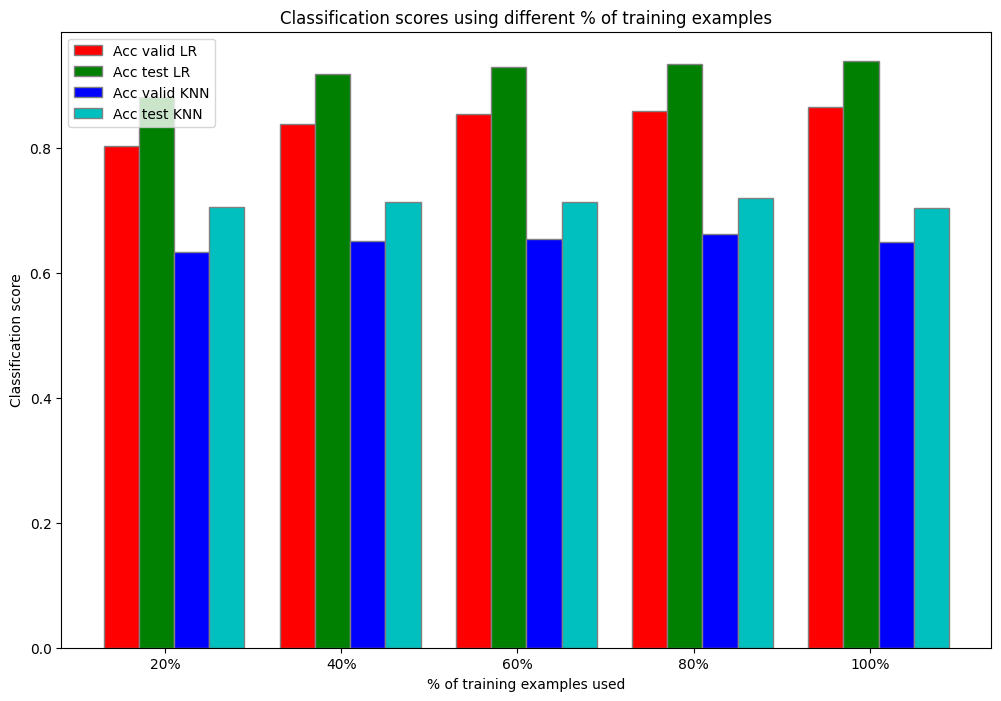

<Figure size 640x480 with 0 Axes>

In [103]:
# set width of bar
barWidth = 0.20
fig = plt.subplots(figsize =(12, 8))

# set height of bar
accLRvalid = [val[0] for val in results_data.values()]
accLRtest = [val[1] for val in results_data.values()]
aucKNNvalid = [val[2] for val in results_data.values()]
aucKNNtest = [val[3] for val in results_data.values()]

# Set position of bar on X axis
br1 = np.arange(len(accLR))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
br4 = [x + barWidth for x in br3]

# Make the plot
plt.bar(br1, accLR, color ='r', width = barWidth, edgecolor ='grey', label ='Acc valid LR ')
plt.bar(br2, accKNN, color ='g', width = barWidth, edgecolor ='grey', label ='Acc test LR')
plt.bar(br3, aucLR, color ='b', width = barWidth, edgecolor ='grey', label ='Acc valid KNN')
plt.bar(br4, aucKNN, color ='c', width = barWidth, edgecolor ='grey', label ='Acc test KNN')

# Adding Xticks
plt.xticks([r + barWidth +0.05 for r in range(len(accLR))], ['20%', '40%', '60%', '80%', '100%'])
plt.xlabel("% of training examples used")
plt.ylabel("Classification score")
plt.title("Classification scores using different % of training examples")

plt.legend()
plt.show()
plt.savefig("data_3.png",bbox_inches='tight', dpi=300)

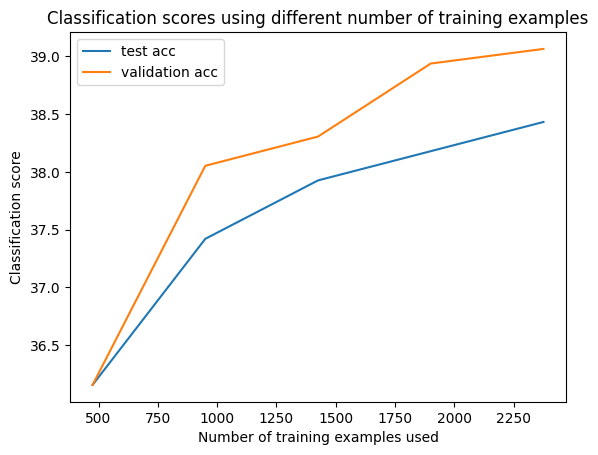

In [179]:
x_label=[475*i for i in range(1,6)]
plt.plot(x_label, [val[1] for val in results_data.values()],  label="test acc")
plt.plot(x_label, [val[0] for val in results_data.values()],   label="validation acc")

plt.xlabel("Number of training examples used")
plt.ylabel("Classification score")
plt.legend()
plt.title("Classification scores using different number of training examples")
plt.savefig("data_3.png",bbox_inches='tight', dpi=300)

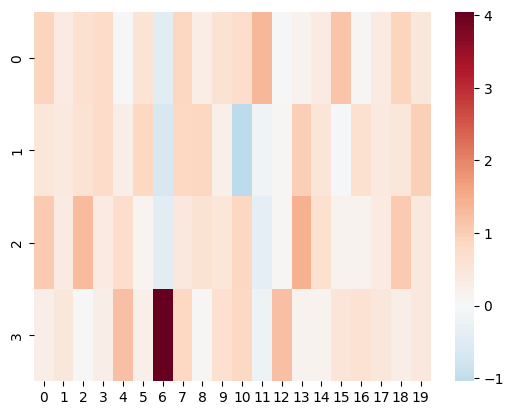

In [123]:
from seaborn import heatmap
best20_features=[]
for l in [max_index_y1, max_index_y2, max_index_y3,max_index_y4]:
    
    for idx in l[:5]:
        
        best20_features.append(union_features.index(idx))
hmp = heatmap(W[best20_features,].T, cmap='RdBu_r', center=0)
fig = hmp.get_figure()
fig.savefig("W_hat.png")

In [46]:
#DONE